# ARIMA model

[Time series forecasting using a hybrid ARIMA and neural network model](https://www.sciencedirect.com/science/article/pii/S0925231201007020)
In an autoregressive integrated moving average model, the future value of a variable is assumed to be a linear function of several past observations and random errors.


### 1. Import and setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from itertools import product
from typing import Union
from statsmodels.graphics.gofplots import qqplot
import itertools
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

UNUSABLE = [
    "Rural population living in areas where elevation is below 5 meters (% of total population)",
    "Access to electricity, rural (% of rural population)",
    "Surface area (sq. km)",
    "Rural land area (sq. km)",
    "Land area (sq. km)",
    "Average precipitation in depth (mm per year)",
    "Agricultural irrigated land (% of total agricultural land)",
    "Rural land area where elevation is below 5 meters (% of total land area)",
    "Rural land area where elevation is below 5 meters (sq. km)"
]

# plot styles
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

### 2. Data upload

In [2]:
df = pd.read_excel('./italy_values_dataset.xlsx')

### 3. Utility functions

In [3]:
def test_stationarity(series):
    """Checks if a time serie is stationary with and ADF test.
    
    Args:
        series (pd.Series with float values): one time serie in the initial dataset.
        
    Returns:
        bool: if p-value < 0.05 returns True [series is stationary],  
                        else it returns False [series is not stationary]
    """
    result = adfuller(series.dropna())
    return result[1] < 0.05

In [24]:
# Assicurati di avere 'adfuller' importato
from statsmodels.tsa.stattools import adfuller

def make_stationary(series, max_d=4):
    """
    Makes a time series stationary by applying sequential differentiations (d=1, d=2...) up to max_d.

    Args:
        series (pd.Series): original time series.
        max_d (int, optional): maximum number of sequential differentiations to try. Default is 4.

    Returns:
        tuple: (stationary_series, d <order of differentiation used>). If it fails, it returns (None, -1).
    """
    
    if test_stationarity(series): 
        print("Serie già stazionaria (d=0)")
        return series.dropna(), 0

    current_series = series.copy()
    for d in range(1, max_d + 1):
        current_series = current_series.diff()
        if len(current_series.dropna()) < 10: 
            print(f"Serie troppo corta dopo d={d}. Impossibile testare.")
            continue
        if test_stationarity(current_series.dropna()):
            print(f"Serie resa stazionaria con d={d}")
            return current_series.dropna(), d
        else:
            print(f"Serie ancora non stazionaria con d={d}")

    print(f"Impossibile rendere stazionaria la serie (testato fino a d={max_d}).")
    return None, -1

In [6]:
def optimize_ARIMA(series, d, max_p=3, max_q=3) -> pd.DataFrame:
    """
    Find the optimal order (p, q) for an ARIMA(p, d, q) model
    while keeping the differentiation order “d” fixed, found with make_stationary.

    Perform a grid search for all combinations of p and q up to 3, and select the model that minimises the AIC.

    Args:
        series (pd.Series or pd.DataFrame): time serie we are analyzing.
            Se è un DataFrame, si assume che la colonna rilevante sia 'Value'.
        d (int): oorder of differentiation that makes the series stationary.
        max_p (int, optional): maximum value of p.
        max_q (int, optional): maximum value of q.

    Returns:
        pd.DataFrame: row with the columns Best order [best p,d,q combination] and Best AIC [relative AIC].
    """
    results = pd.DataFrame(columns=['Best order', 'Best AIC'])
    best_aic = float('inf')
    best_order = None
    data = series
    if isinstance(series, pd.DataFrame):
        data = series['Value']
    for p, q in itertools.product(range(max_p + 1),
                                    range(max_q + 1)):
        try:
            model = ARIMA(data, order=(p, d, q))
            fitted_model = model.fit()
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_order = (p, d, q)
        except Exception:
            continue
    if best_order is not None:
        results.loc[0] = [best_order, best_aic]
    else:
        results.loc[0] = [None, np.nan]
    return results

In [7]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, p: int, d: int, q: int) -> list:
    """ Walk-forward forecast on time serie. 
    Trains a model on first 'train_len' data, forecasts subsequent 'window' steps. 
    Adds real data of 'window' steps to train set and repeats until the 'horizon' is completed.

    Args:
        df (pd.DataFrame): contains time serie. Must contain a "Value" col.
        train_len (int): initial dimension of train set
        horizon (int): total number of periods to forecast (es. 13, dimension of test set) 
        window (int): steps number to forecast in each iteration befor re-training model.
        method (str): forecast method. Accepts 'mean', 'last' or 'ARIMA'
        p (int): optimal p order
        d (int): d number of differentiations needed to make the time serie stationary
        q (int): optimal q order

    Returns:
        list: forecast for the whole horizon.
    """
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df["Value"][:i])
            pred_mean.extend([mean] * window)
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df["Value"][:i].iloc[-1]
            pred_last_value.extend([last_value] * window)
        return pred_last_value

    elif method == 'ARIMA':
        pred_ARIMA = []
        for i in range(train_len, total_len, window):
            # controllo: se non ci sono abbastanza osservazioni, salto
            if len(df["Value"][:i]) < 10:
                pred_ARIMA.extend([np.nan] * window)
                continue
            try:
                model = ARIMA(df["Value"][:i], order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
                res = model.fit()
                predictions = res.get_prediction(start = i, end = i + window - 1)
                oos_pred = predictions.predicted_mean
                pred_ARIMA.extend(oos_pred)
            except Exception as e:
                print(f"Errore ARMA per finestra {i}: {e}")
                pred_ARIMA.extend([np.nan] * window)
        return pred_ARIMA

### 4. Finding optimal p, d, q orders for each time serie

In [22]:
indicators = [i for i in df["Indicator Name"].unique() if i not in UNUSABLE]
df_orders = pd.DataFrame(columns=["Indicator", "Best order", "Best AIC"])

if __name__ == "__main__":
    """ Prende solo gli indicatori usabili e itera su quelli
    crea un df temporaneo con la time serie che sto studiando
    crea nuovo df con time serie rese stazionarie e salva d numero di differenziazioni necessarie
    trova valori di p e q ottimali per la time serie per ottenere l'ordine (p,d,q) migliore [con d già dato]
    """
    for indicator in indicators:
        df_temp = (
            df[df["Indicator Name"] == indicator]
            .melt(id_vars=["Indicator Name"], var_name="Year", value_name="Value")
            .assign(Year=lambda d: d["Year"].astype(int))
            .dropna(subset=["Value"])
            [["Year", "Value"]]
            .reset_index(drop=True)
        )
        if df_temp.empty or len(df_temp) < 20 or df_temp['Value'].nunique() == 1:
            continue

        print(f"========================== {indicator} ==========================")    
        df_stat, d = make_stationary(df_temp['Value'])
        best_df = optimize_ARIMA(df_stat, d)
        if not best_df.empty and pd.notnull(best_df.loc[0, 'Best order']):
                best_order = best_df.loc[0, 'Best order']
                best_aic = best_df.loc[0, 'Best AIC']
                new_row = pd.DataFrame({
                    'Indicator': [indicator],
                    'Best order': [best_order],
                    'Best AIC': [best_aic]
                })
                df_orders = pd.concat([df_orders, new_row], ignore_index=True)
                print(f"Best order = {best_order}, AIC = {best_aic:.3f}")
    print(df_orders)

========================== Rural population (% of total population) ==========================
Serie resa stazionaria con d=1


C:\Users\oldan\AppData\Local\Temp\ipykernel_3324\1813710091.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_orders = pd.concat([df_orders, new_row], ignore_index=True)


Best order = (0, 1, 1), AIC = -239.099
========================== Rural population growth (annual %) ==========================
Serie resa stazionaria con d=1
Best order = (0, 1, 1), AIC = -9.464
========================== Rural population ==========================
Serie ancora non stazionaria con d=1
Serie resa stazionaria con d=2
Best order = (2, 2, 2), AIC = 1489.512
========================== Employment in agriculture (% of total employment) ==========================
Serie già stazionaria (d=0)
Best order = (2, 0, 3), AIC = 4.310
========================== Employment in agriculture, male (% of male employment) ==========================
Serie già stazionaria (d=0)
Best order = (3, 0, 3), AIC = 3.736
========================== Employment in agriculture, female (% of female employment) ==========================
Serie già stazionaria (d=0)
Best order = (2, 0, 3), AIC = 23.882
========================== Forest area (% of land area) ==========================
Serie già stazionaria (d

### 5. Plotting for easy understanding

In [26]:
def plot_forecasts(indicator, train, test):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13,5))
    fig.suptitle(f"Comparison on forecasting methods for {indicator}", fontsize=14, fontweight="bold")
    ax1.plot(train['Year'], train['Value'])
    ax1.plot(test['Year'], test['Value'], color = colors[0], linestyle='-', label='actual')
    ax1.plot(test['Year'], test['pred_mean'], color = colors[1], linestyle=':', label='mean')
    ax1.plot(test['Year'], test['pred_last_value'], color = colors[2], linestyle='-.', label='last')
    ax1.plot(test['Year'], test['pred_ARIMA'], color = colors[3], linestyle='--', label=f'ARIMA{(p,d,q)}')
    ax1.legend(loc=2)
    ax1.set_title("Full time series")
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    start_year = int(test['Year'].iloc[0])
    end_year = int(test['Year'].iloc[-1])
    ax1.axvspan(start_year - 0.5, end_year + 0.5, color='#808080', alpha=0.2)
    
    ax2.plot(test['Year'], test['Value'], color = colors[0], linestyle='-', label='Actual', marker="o")
    ax2.plot(test['Year'], test['pred_mean'], color = colors[1], linestyle=':', label='Mean', marker="s")
    ax2.plot(test['Year'], test['pred_last_value'], color = colors[2], linestyle='-.', label='Last', marker="^")
    ax2.plot(test['Year'], test['pred_ARIMA'], color = colors[3], linestyle='--', label=f'ARIMA{(p,d,q)}', marker="d")
    ax2.legend(loc=2)
    ax2.set_title("Zoom on test set")
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    ax1.tick_params(labelbottom=True)
    ax2.tick_params(labelbottom=True) 
    plt.setp(ax2.get_xticklabels(), visible=True)
    plt.tight_layout()
    plt.show()

In [25]:
def plot_error(results):
    """ Plots error comparison for easy understanding of better model

    Args:
        results (dict): dictionary with methods used and relative mae and mse values associated
    """
    fig, ax = plt.subplots()
    x = np.arange(len(results['Method']))
    width = 0.35

    # GRAFICO MSE e MAE
    ax.bar(x - width/2, results['MSE'], width, label='MSE')
    ax.bar(x + width/2, results['MAE'], width, label='MAE')
    ax.set_xticks(x)
    ax.set_xticklabels(results['Method'])
    ax.set_title("Error on predictions")
    ax.set_ylabel("Error")
    ax.legend()
    ax.grid(alpha=0.3)

    for idx in x:
        ax.text(idx - width/2, results['MSE'][idx] + 0.02*(results['MSE'][idx]), f"{results['MSE'][idx]:.5f}", ha='center', va='bottom')
        ax.text(idx + width/2, results['MAE'][idx] + 0.02*(results['MAE'][idx]), f"{results['MAE'][idx]:.5f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

================= Rural population (% of total population) ===================


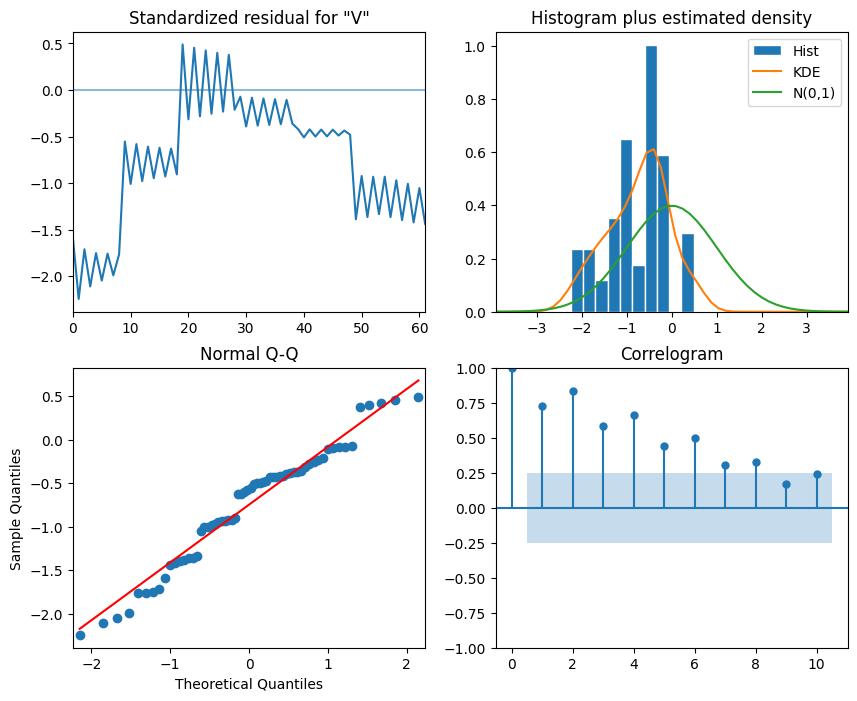

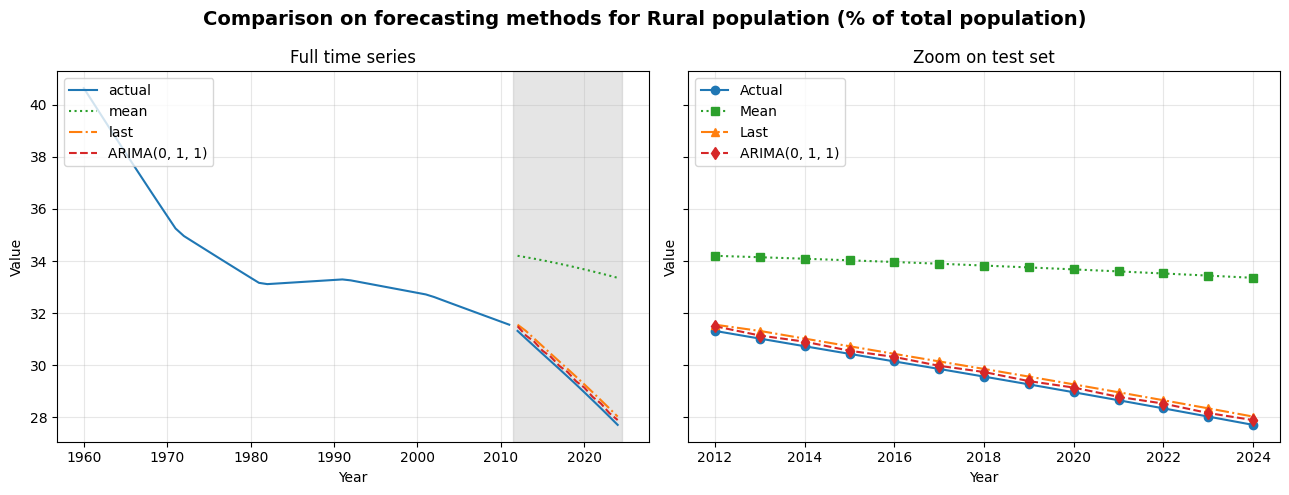

MAE -> mean: 4.26833, last: 0.29600, ARIMA(0, 1, 1): 0.15402
MSE -> mean: 18.95034, last: 0.08797, ARIMA(0, 1, 1): 0.02447


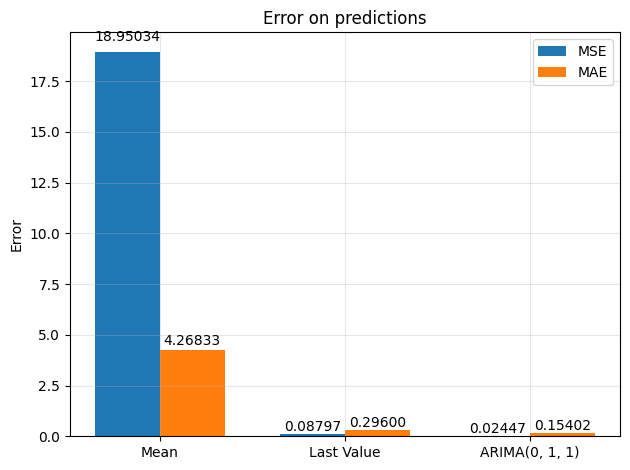

================= Rural population growth (annual %) ===================


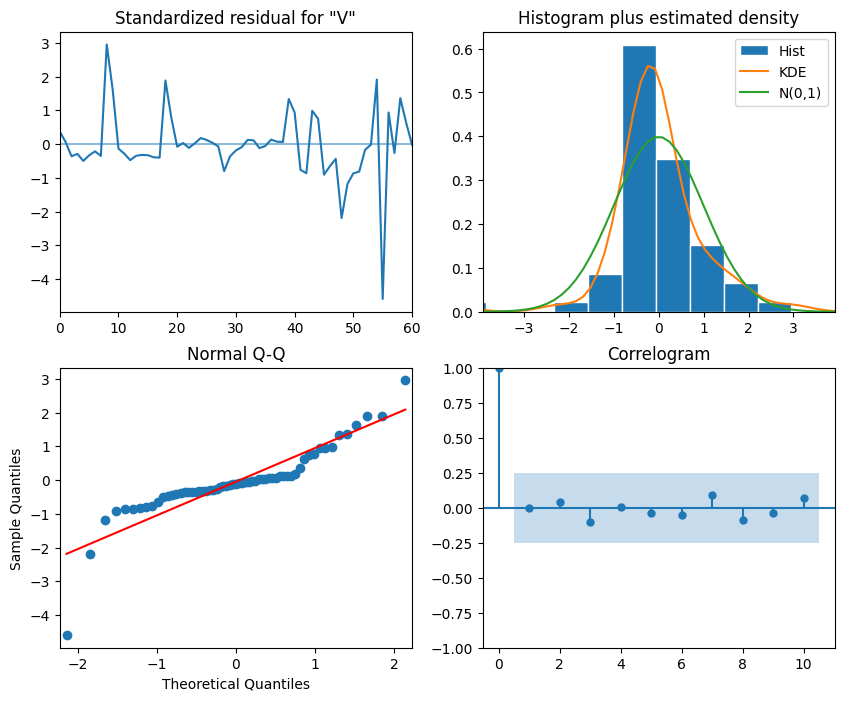

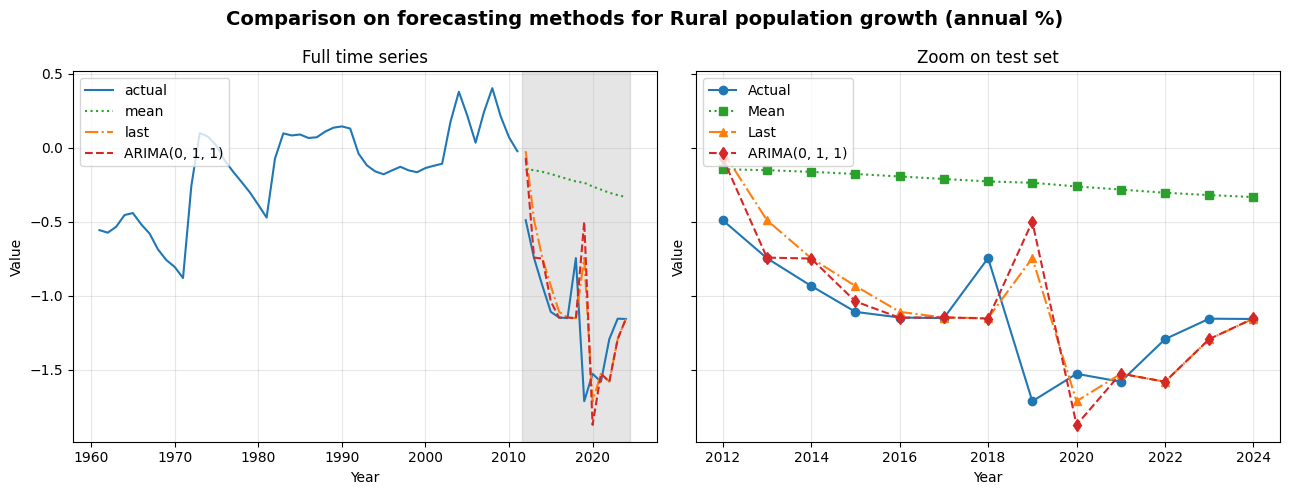

MAE -> mean: 0.90313, last: 0.24361, ARIMA(0, 1, 1): 0.24150
MSE -> mean: 0.90891, last: 0.12227, ARIMA(0, 1, 1): 0.16005


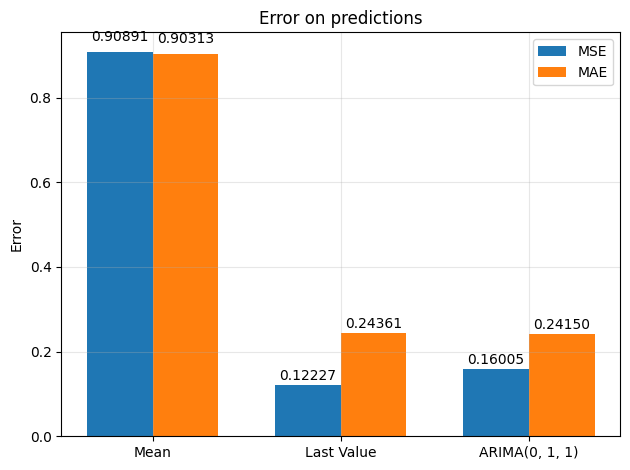

================= Rural population ===================


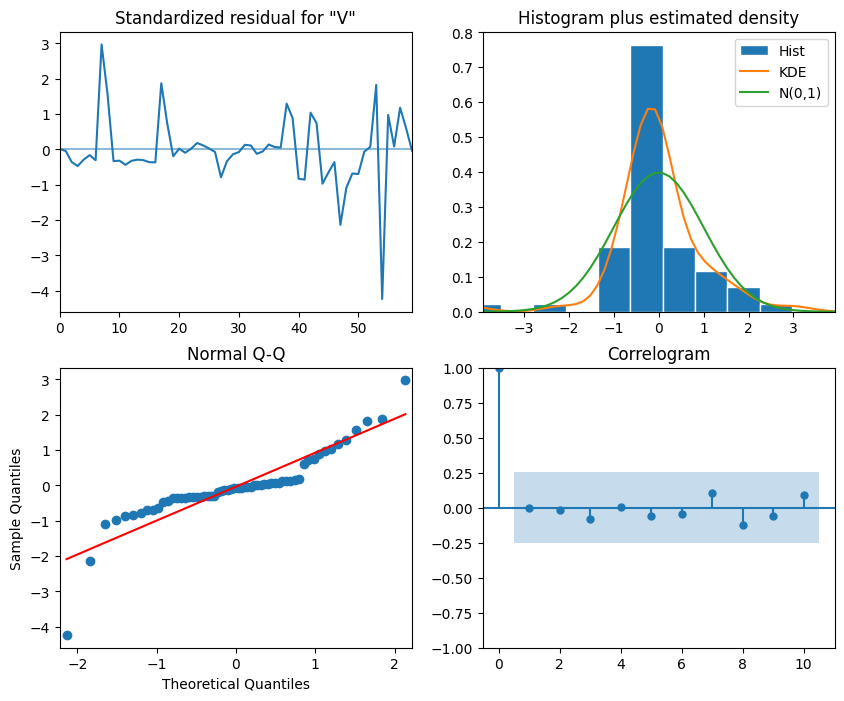

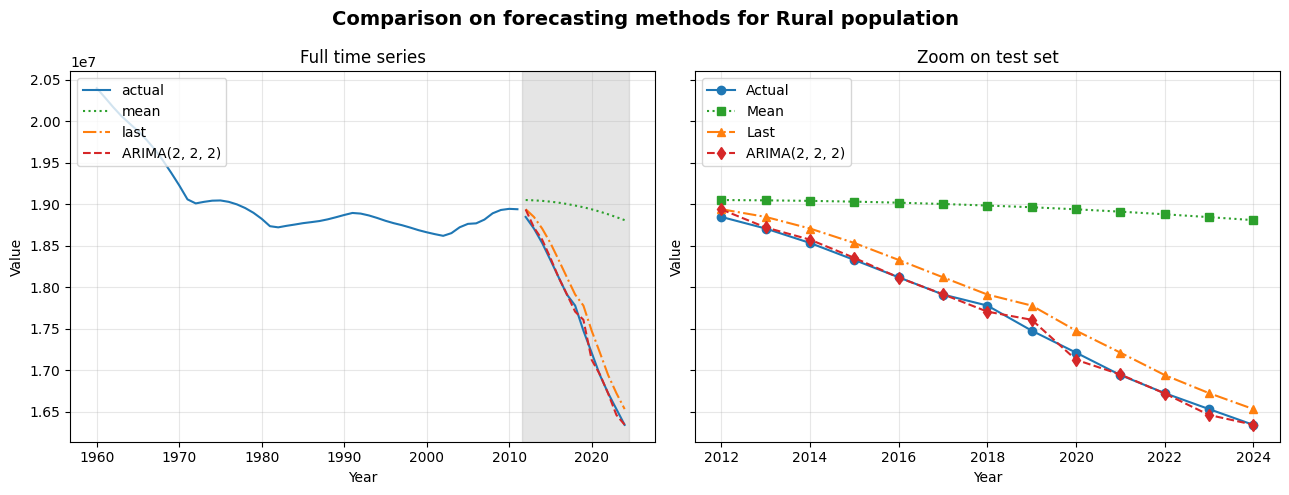

MAE -> mean: 1312813.92408, last: 199863.30769, ARIMA(2, 2, 2): 42140.26557
MSE -> mean: 2269921707874.83447, last: 43056462742.53846, ARIMA(2, 2, 2): 3495175027.28822


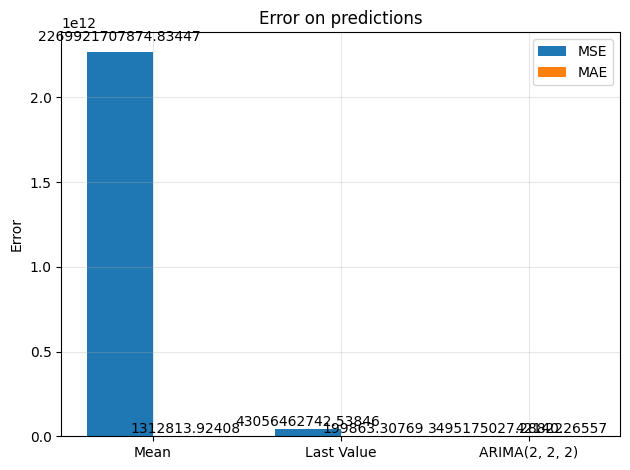

================= Forest area (sq. km) ===================


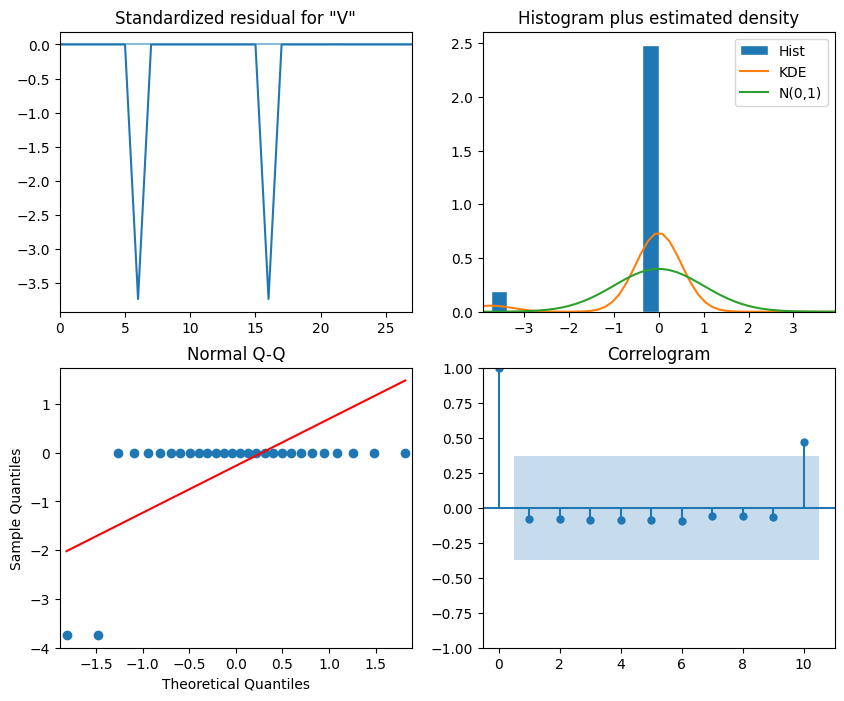

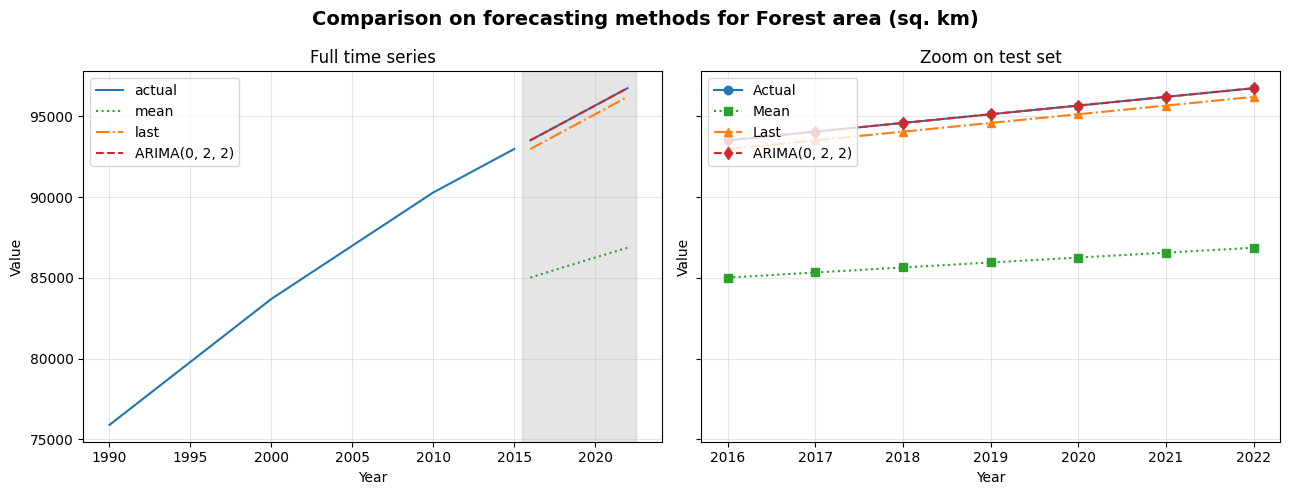

MAE -> mean: 9179.60486, last: 538.10000, ARIMA(0, 2, 2): 0.00286
MSE -> mean: 84478060.69717, last: 289551.61000, ARIMA(0, 2, 2): 0.00006


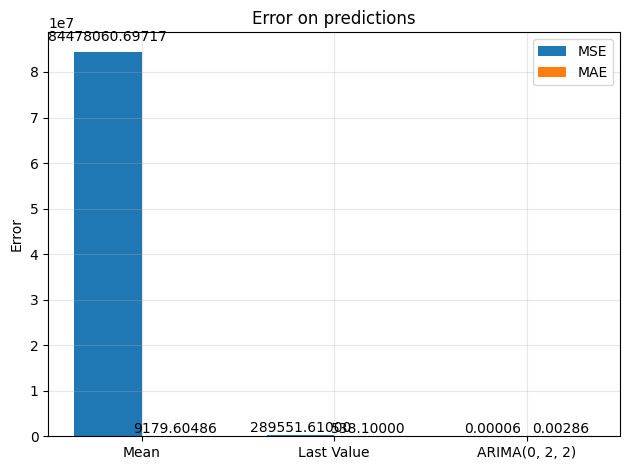

================= Agricultural land (% of land area) ===================


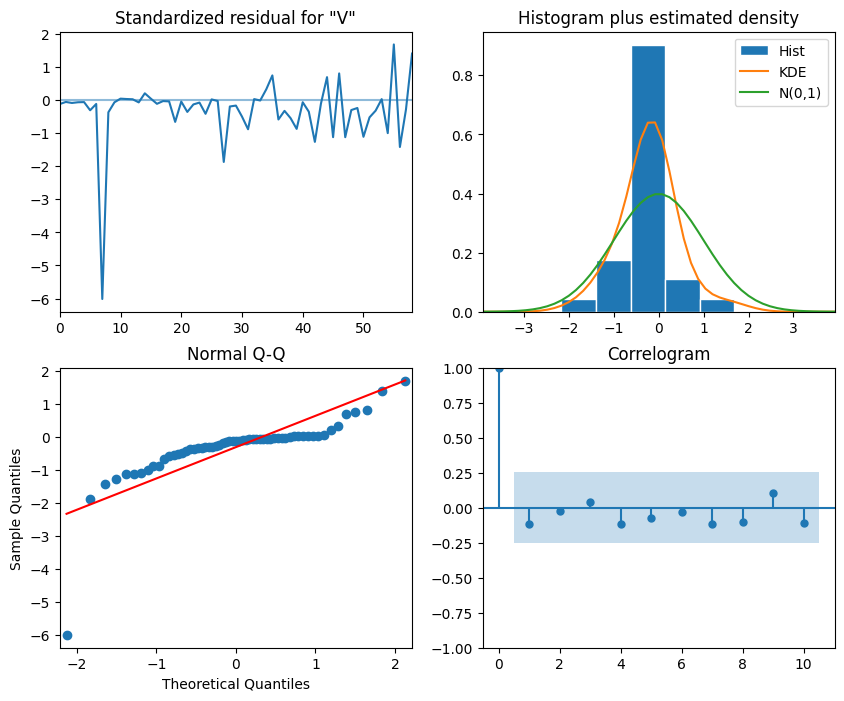

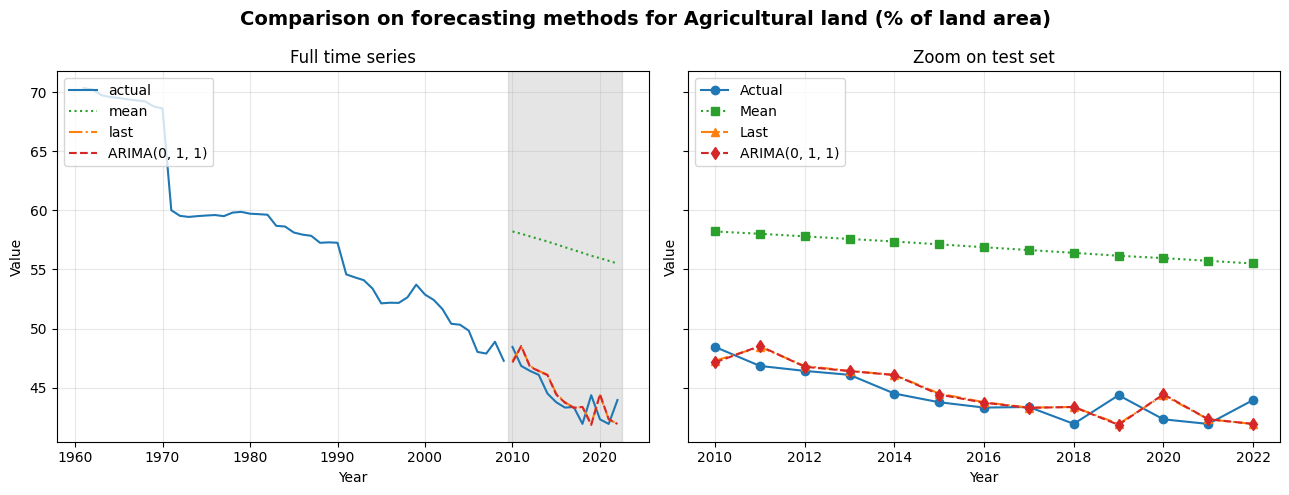

MAE -> mean: 12.46213, last: 1.12605, ARIMA(0, 1, 1): 1.14203
MSE -> mean: 157.01830, last: 1.82802, ARIMA(0, 1, 1): 1.91597


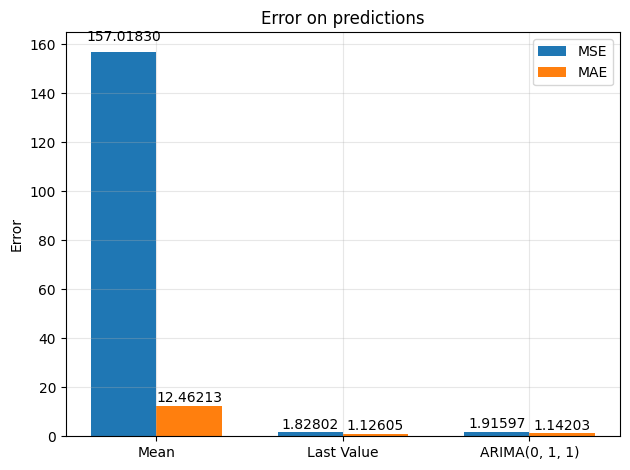

================= Agricultural land (sq. km) ===================


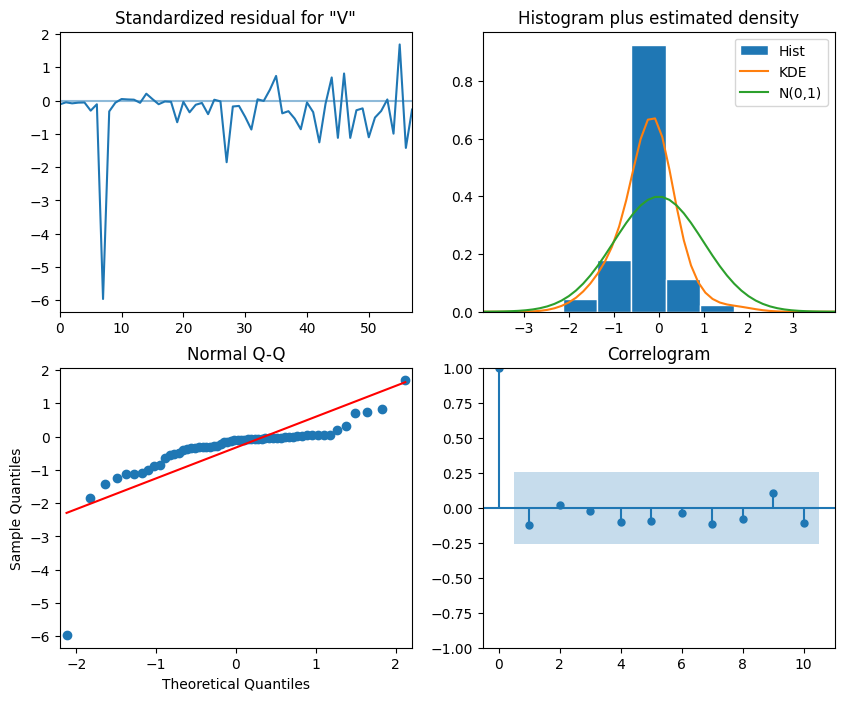

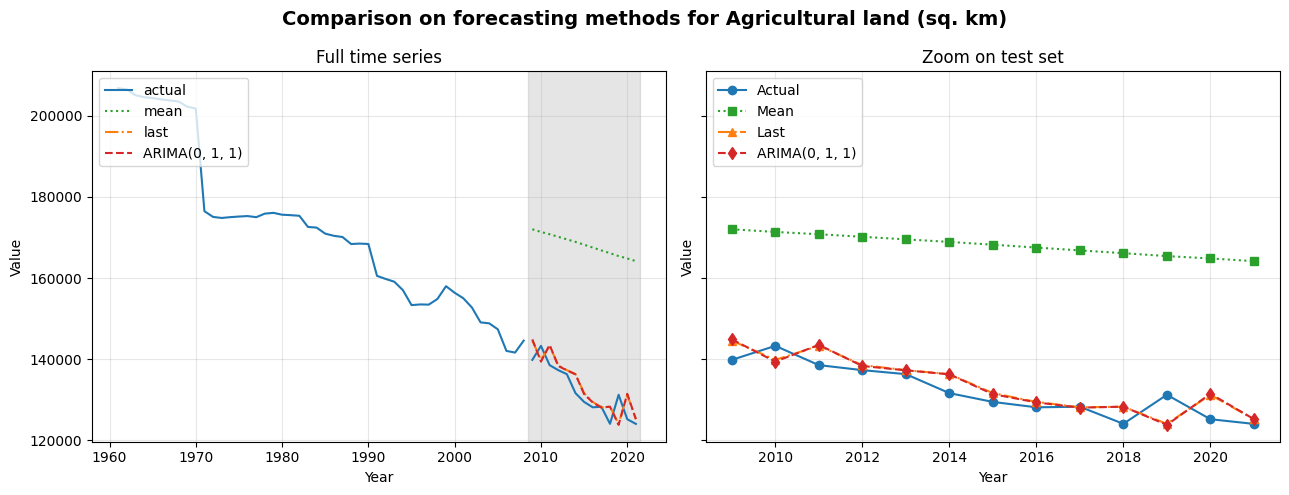

MAE -> mean: 36061.33185, last: 3235.41008, ARIMA(0, 1, 1): 3306.99883
MSE -> mean: 1316287883.00967, last: 14972204.32074, ARIMA(0, 1, 1): 15992536.91782


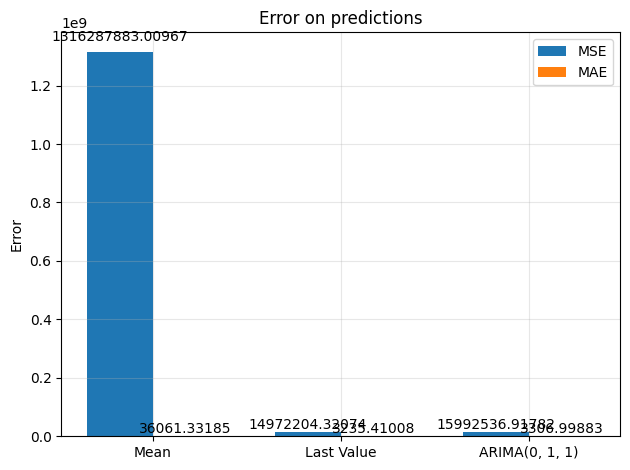

================= Arable land (% of land area) ===================


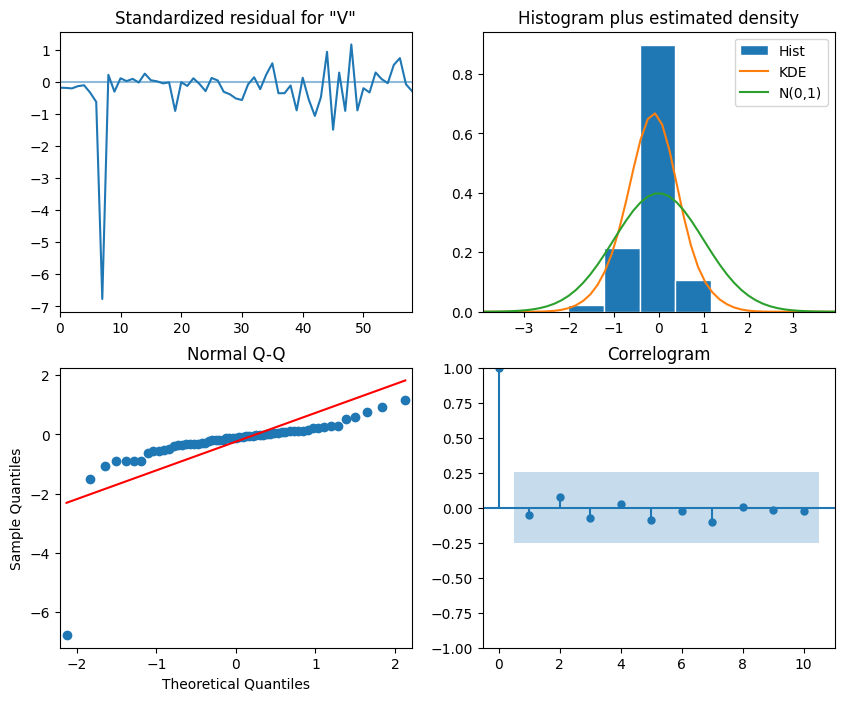

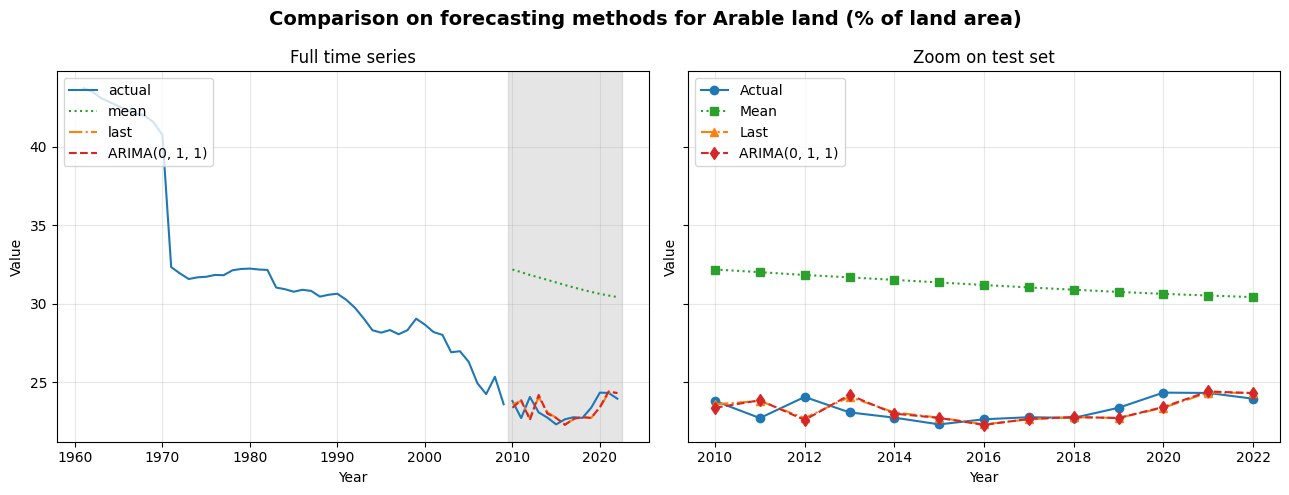

MAE -> mean: 7.93496, last: 0.53013, ARIMA(0, 1, 1): 0.56521
MSE -> mean: 63.97349, last: 0.45483, ARIMA(0, 1, 1): 0.51027


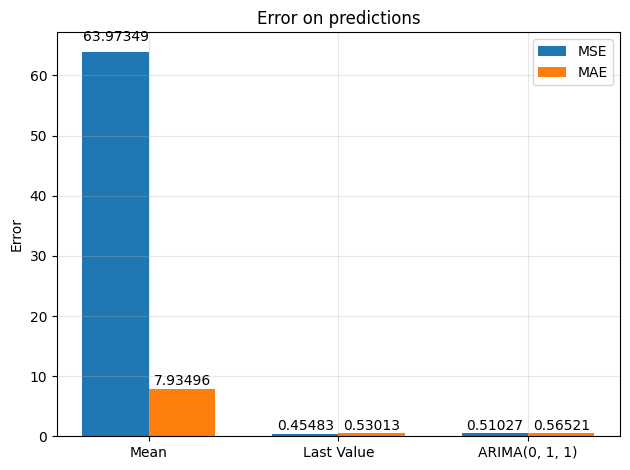

================= Arable land (hectares per person) ===================


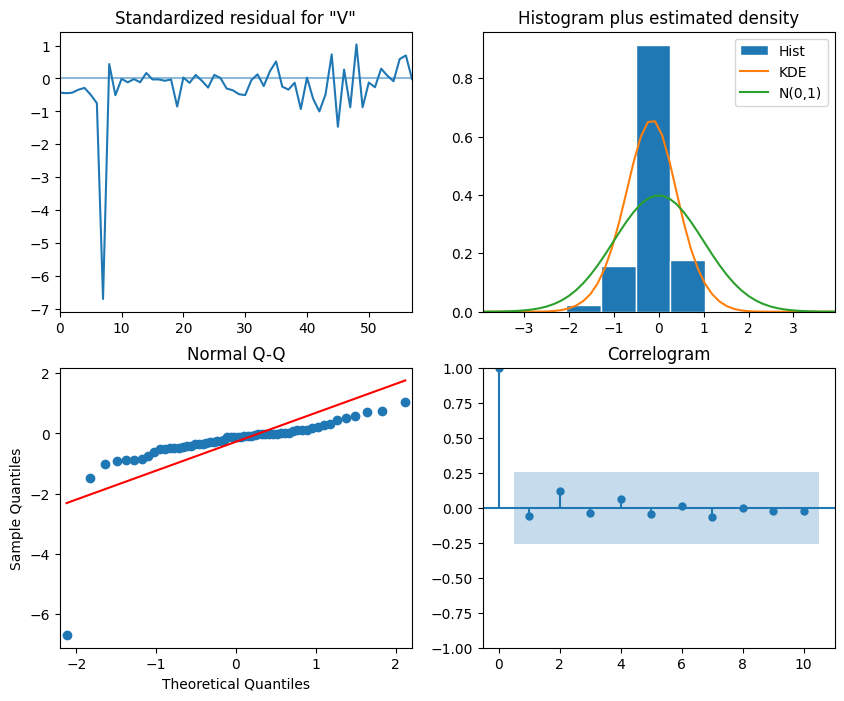

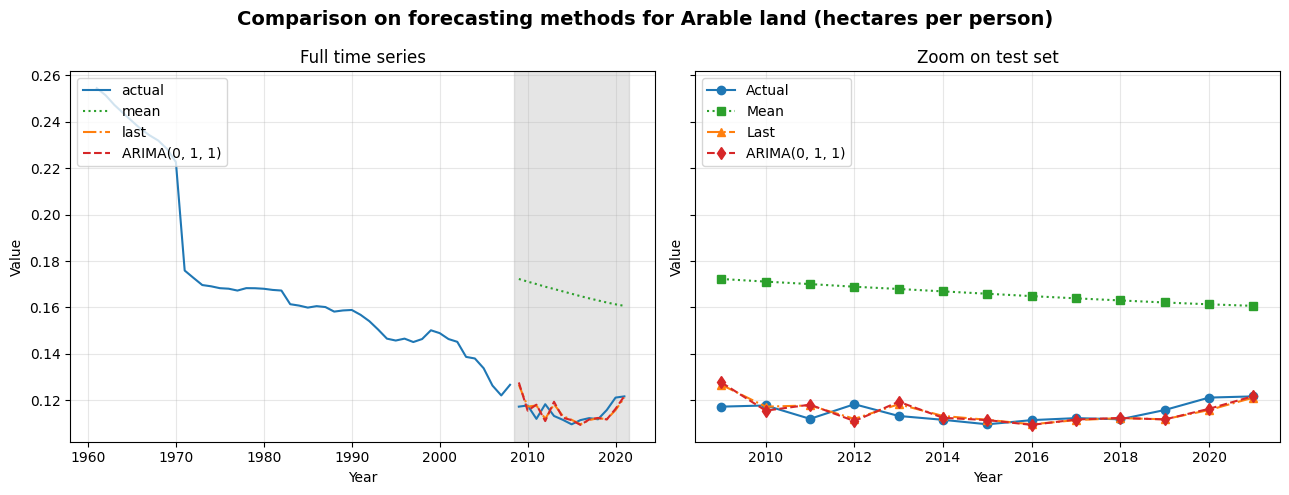

MAE -> mean: 0.05119, last: 0.00336, ARIMA(0, 1, 1): 0.00362
MSE -> mean: 0.00265, last: 0.00002, ARIMA(0, 1, 1): 0.00002


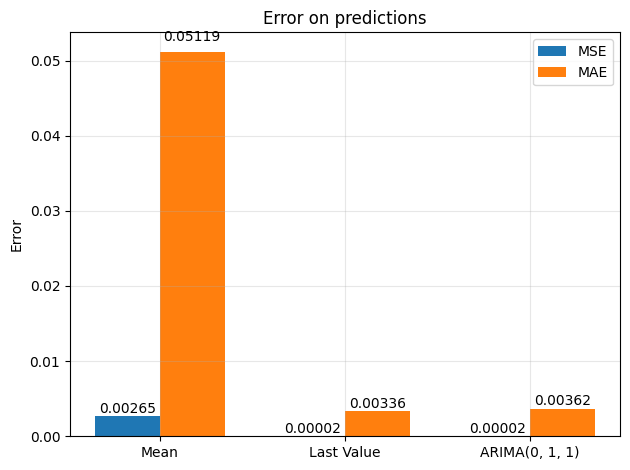

================= Arable land (hectares) ===================


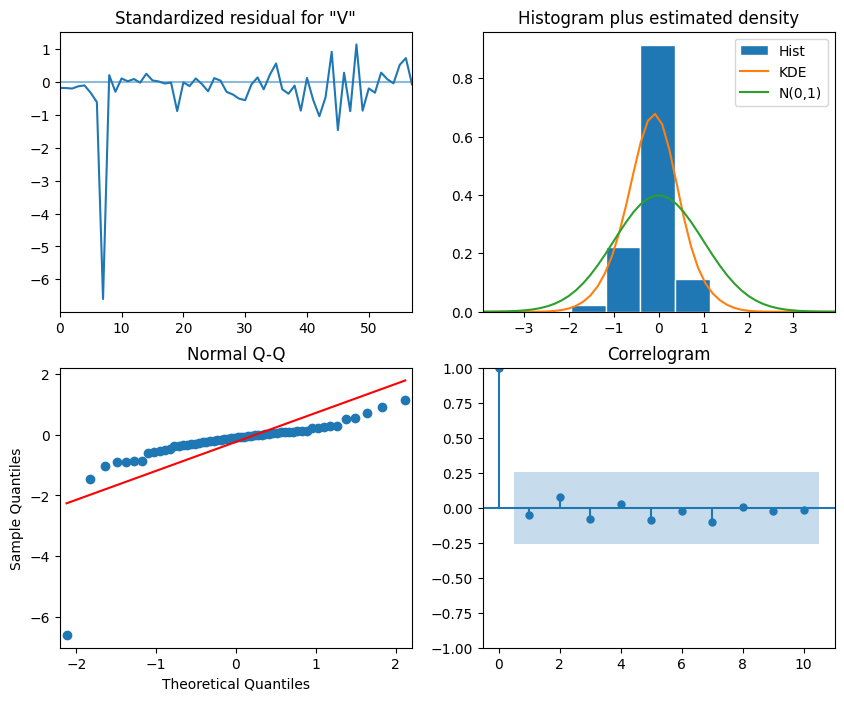

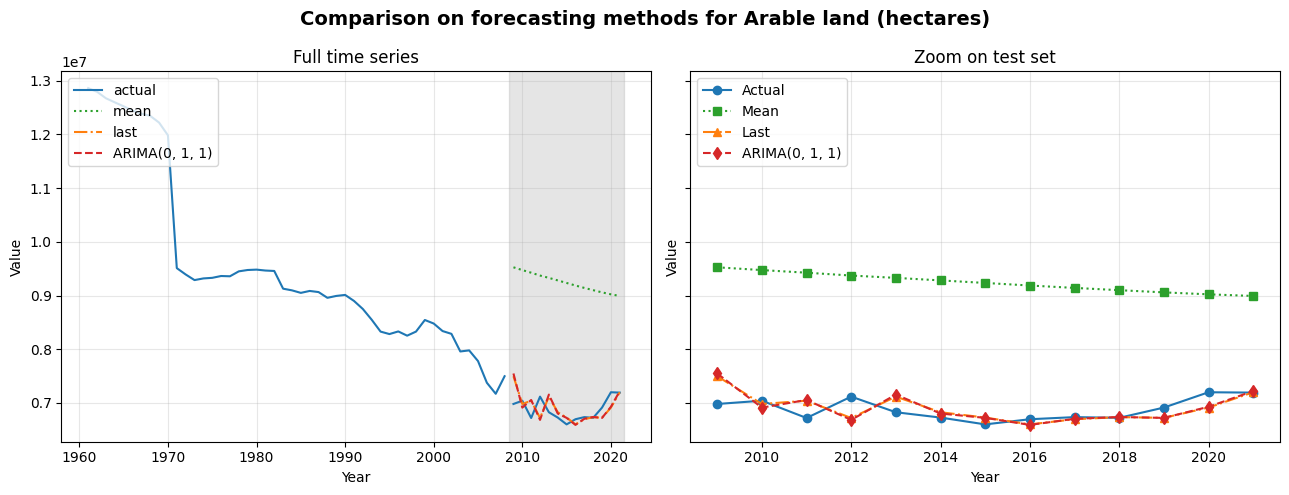

MAE -> mean: 2359215.92462, last: 188196.61538, ARIMA(0, 1, 1): 202685.04363
MSE -> mean: 5640545183646.05273, last: 59430344234.92308, ARIMA(0, 1, 1): 68575816069.67319


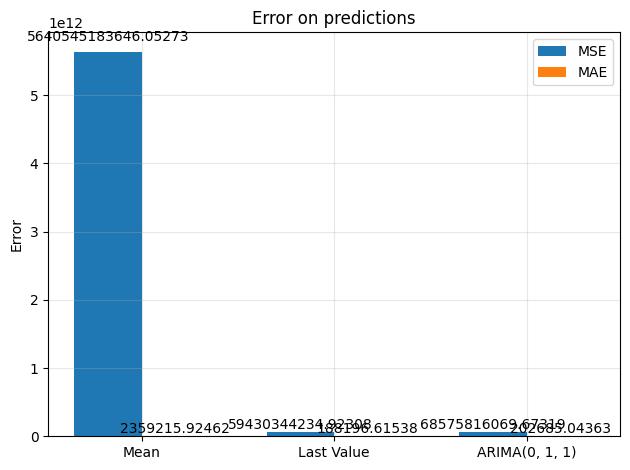

================= Land under cereal production (hectares) ===================


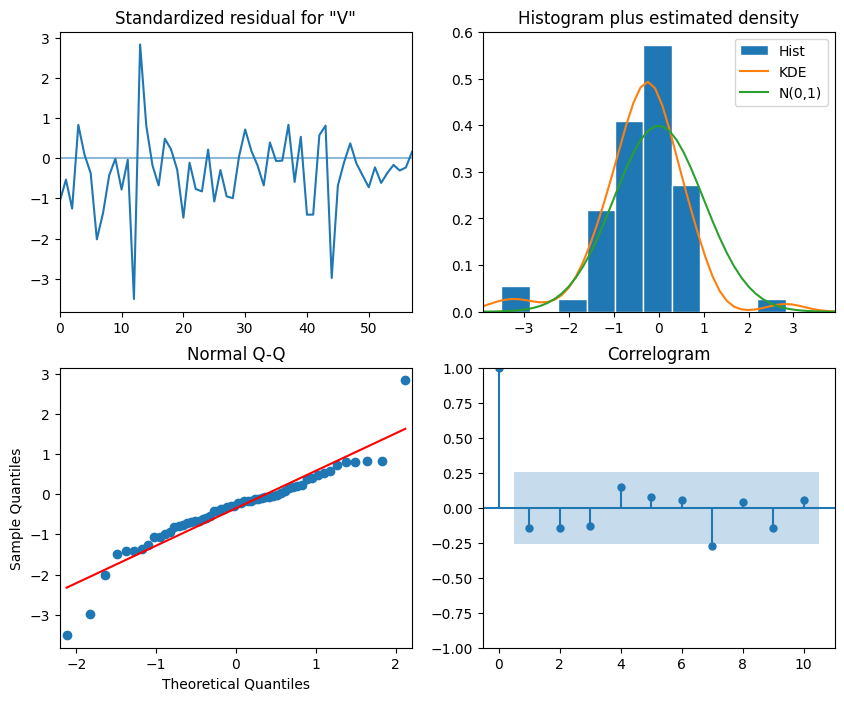

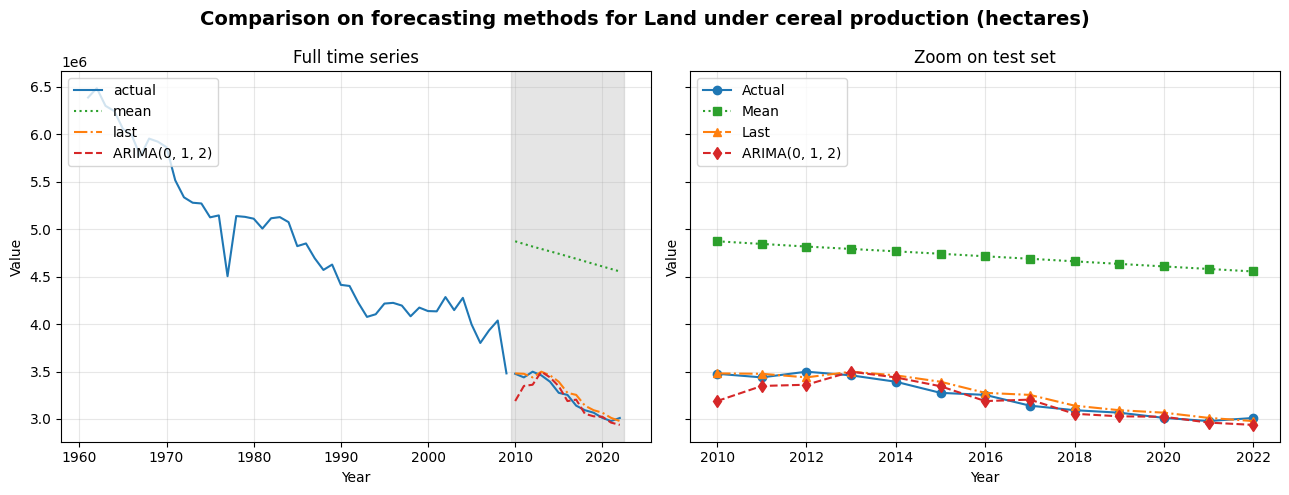

MAE -> mean: 1475336.59622, last: 50329.46154, ARIMA(0, 1, 2): 74906.30512
MSE -> mean: 2186211688149.47363, last: 3554542699.76923, ARIMA(0, 1, 2): 10367292445.22341


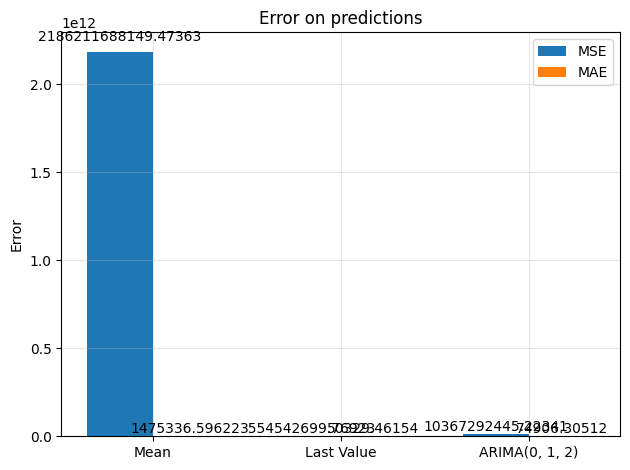

================= Permanent cropland (% of land area) ===================


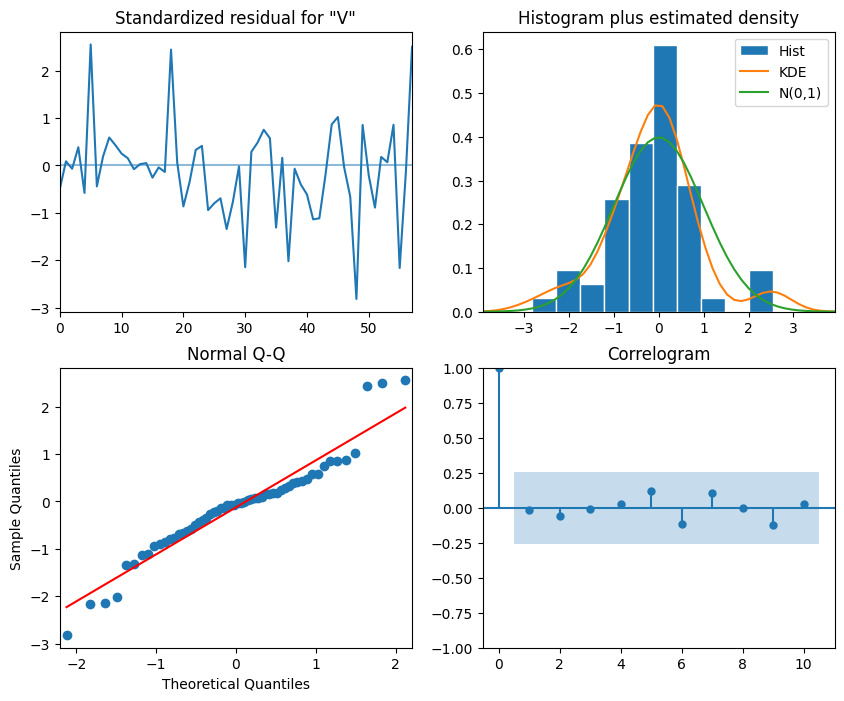

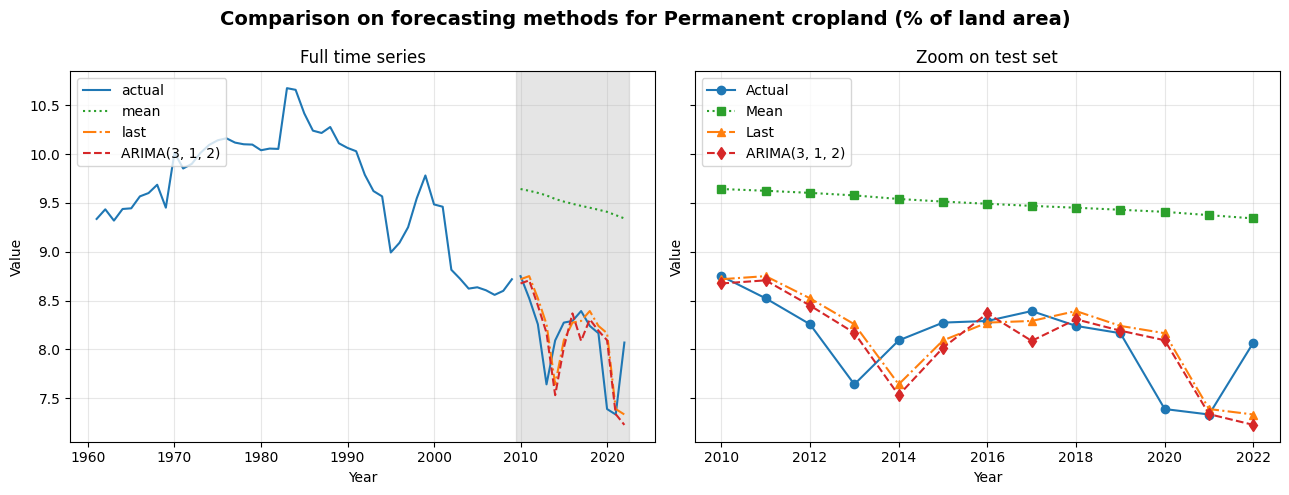

MAE -> mean: 1.38846, last: 0.28368, ARIMA(3, 1, 2): 0.29426
MSE -> mean: 2.05661, last: 0.14824, ARIMA(3, 1, 2): 0.15753


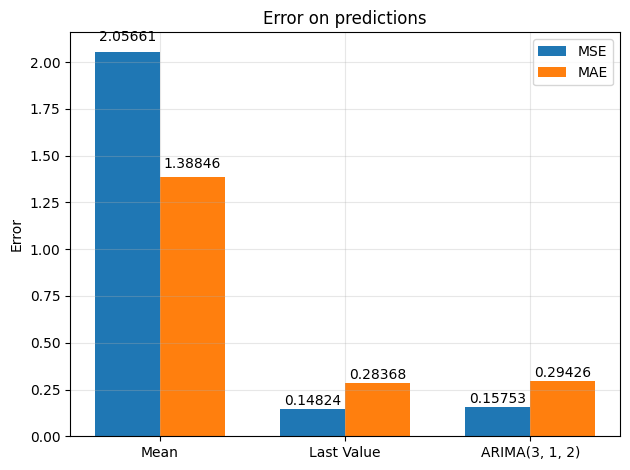

================= Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal) ===================


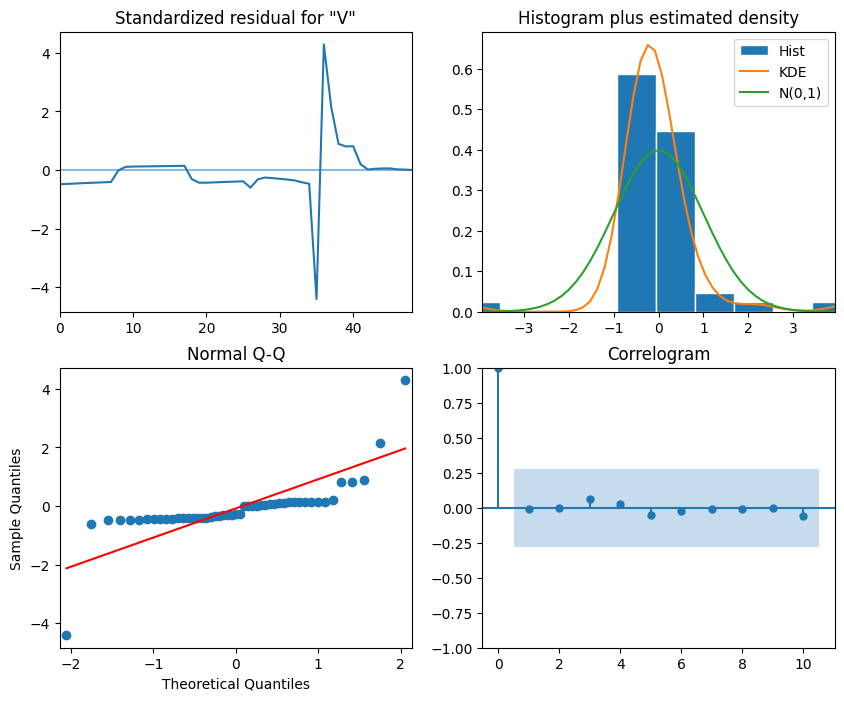

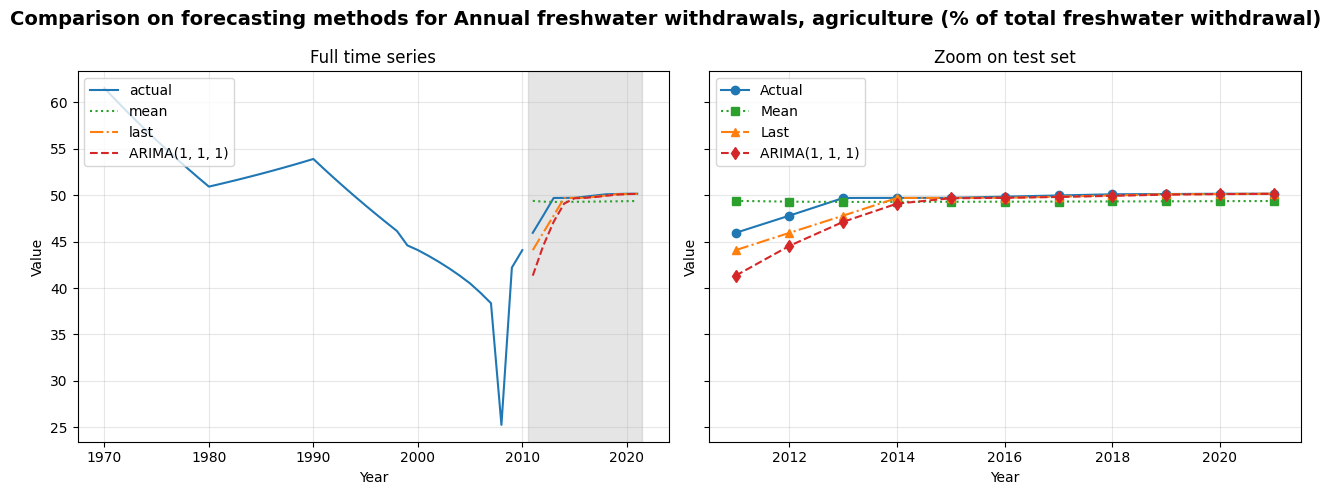

MAE -> mean: 0.96152, last: 0.55247, ARIMA(1, 1, 1): 1.06234
MSE -> mean: 1.62397, last: 0.96255, ARIMA(1, 1, 1): 3.54163


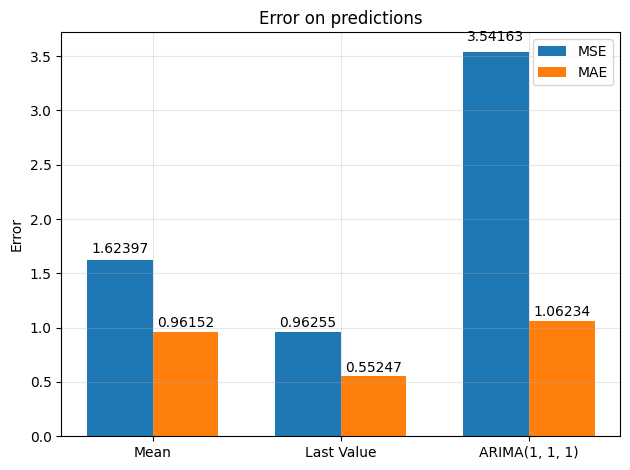

================= Fertilizer consumption (kilograms per hectare of arable land) ===================


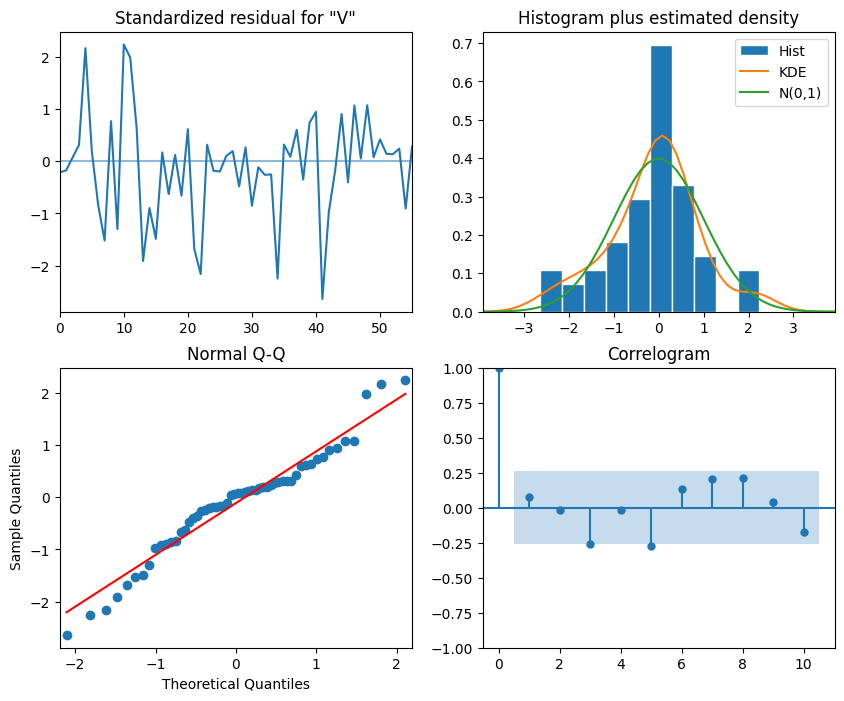

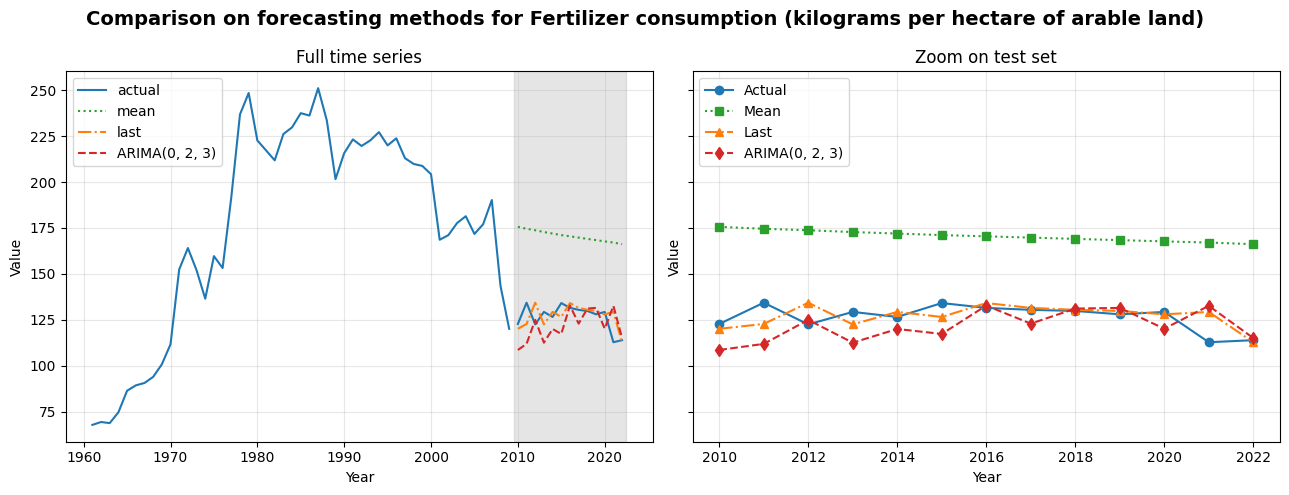

MAE -> mean: 44.08990, last: 5.24086, ARIMA(0, 2, 3): 9.44360
MSE -> mean: 1981.20096, last: 52.13985, ARIMA(0, 2, 3): 143.40310


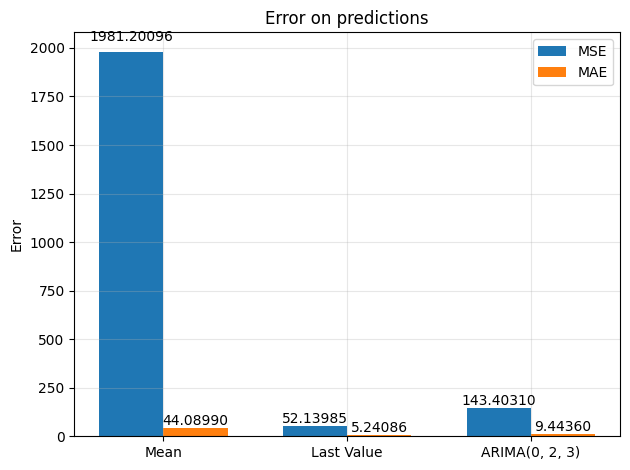

================= Fertilizer consumption (% of fertilizer production) ===================


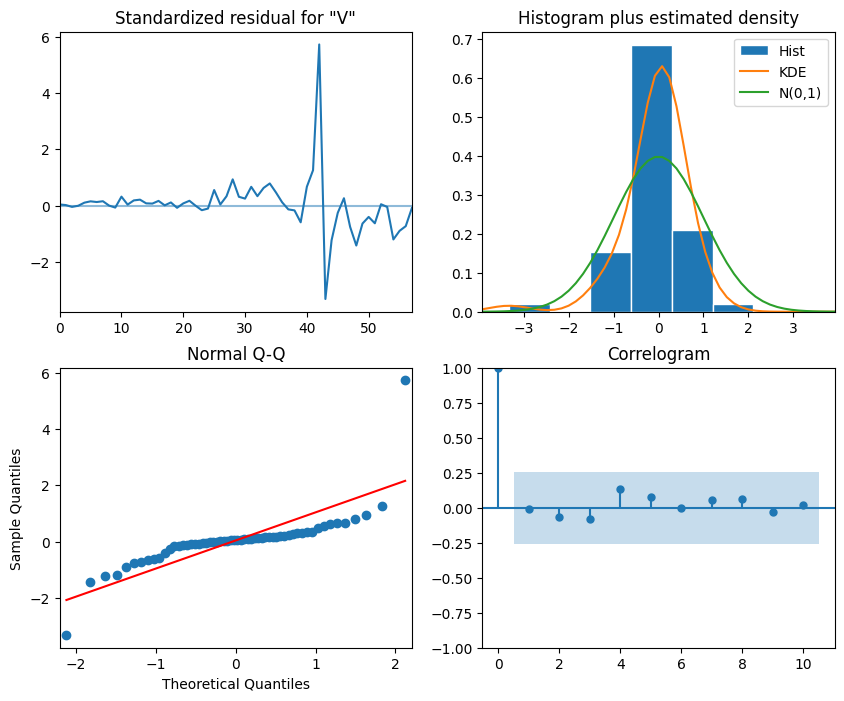

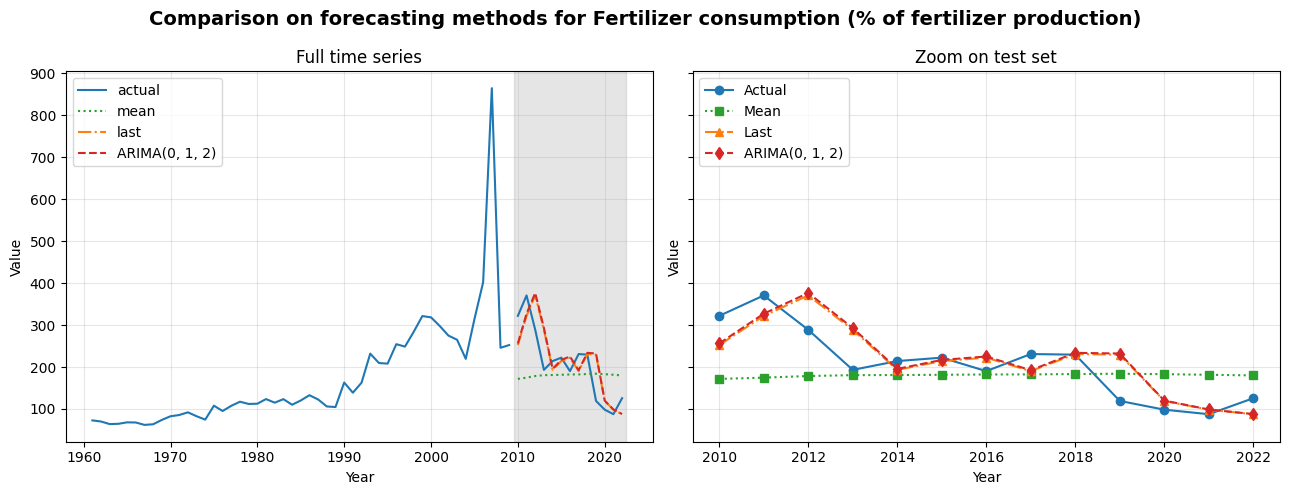

MAE -> mean: 72.60183, last: 44.56338, ARIMA(0, 1, 2): 44.83864
MSE -> mean: 7984.55842, last: 3109.78003, ARIMA(0, 1, 2): 3218.07788


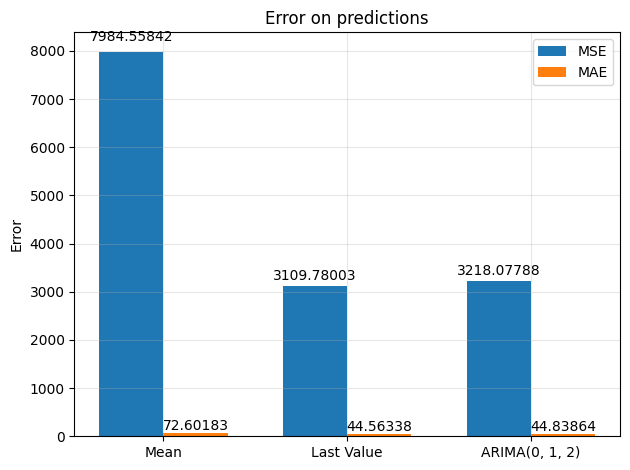

================= Livestock production index (2014-2016 = 100) ===================


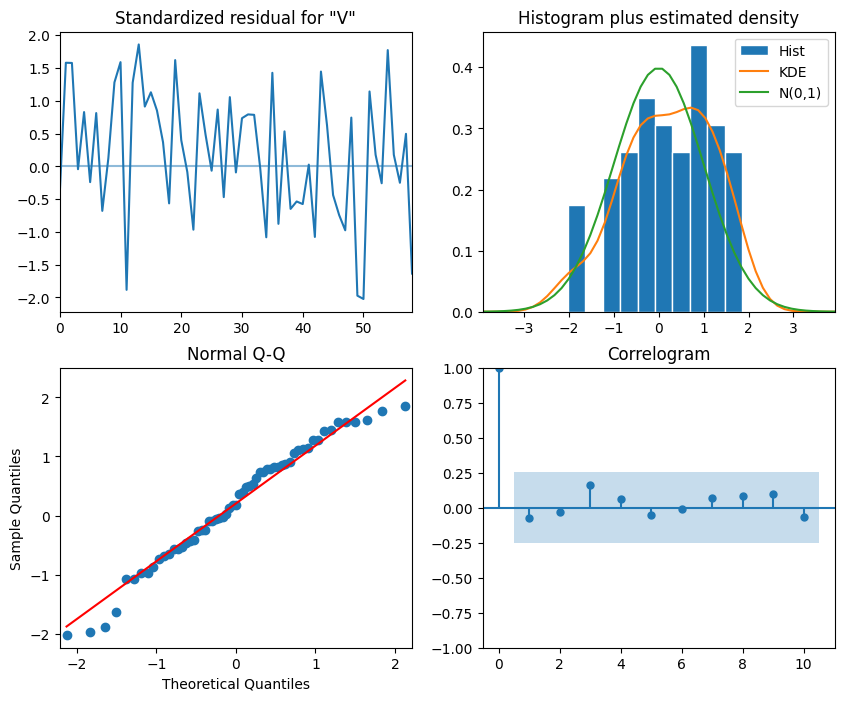

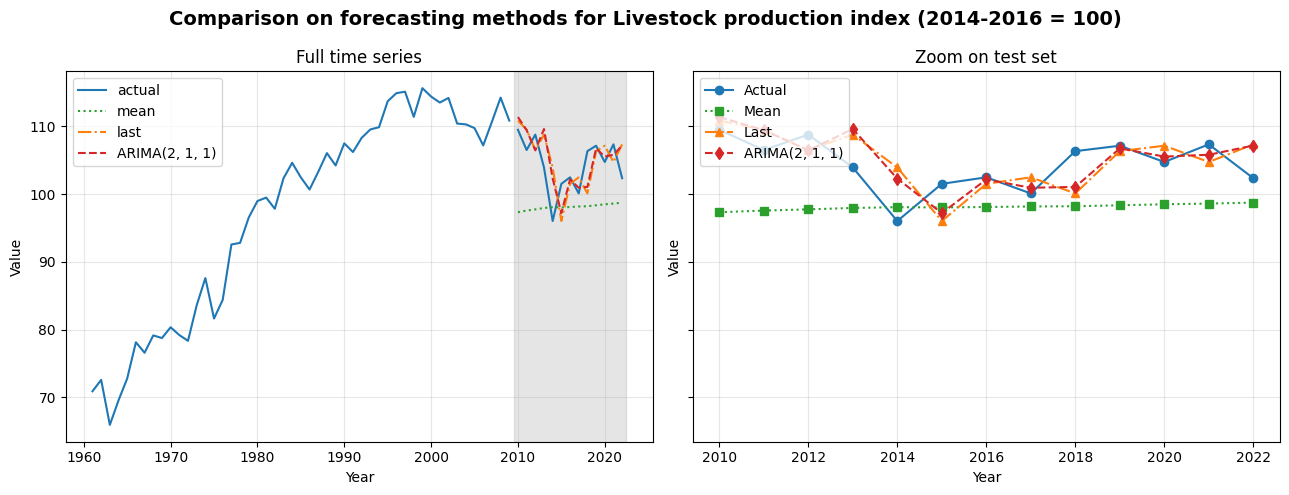

MAE -> mean: 6.56998, last: 3.47846, ARIMA(2, 1, 1): 2.87413
MSE -> mean: 53.50600, last: 16.57994, ARIMA(2, 1, 1): 12.49991


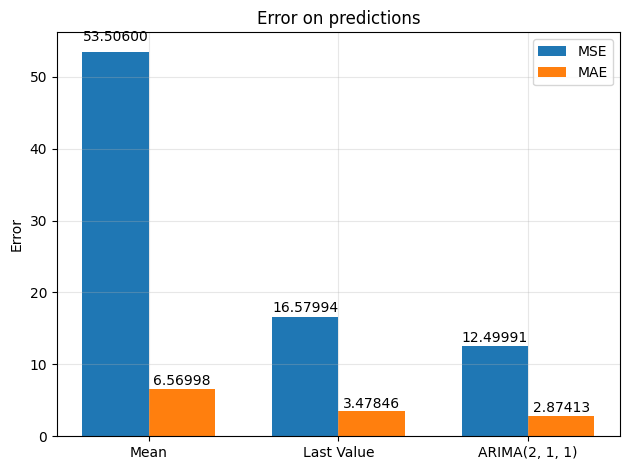

================= Food production index (2014-2016 = 100) ===================


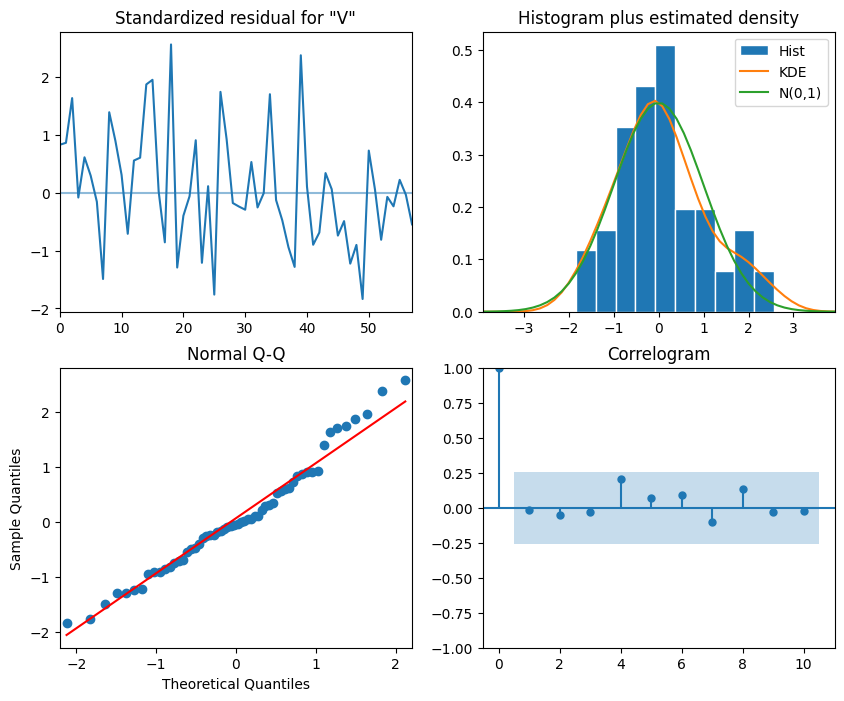

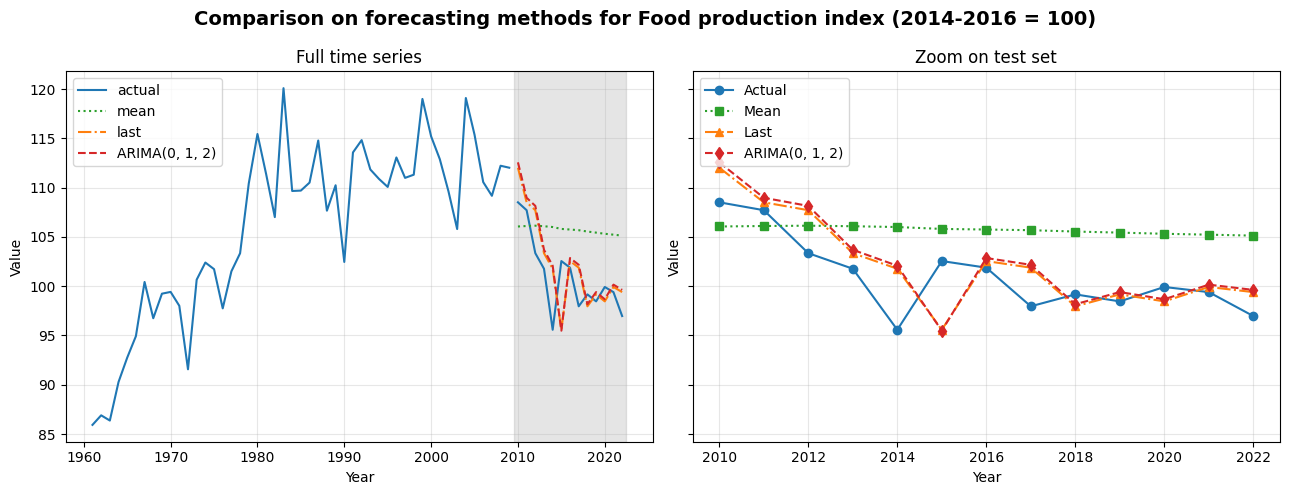

MAE -> mean: 5.32075, last: 2.64077, ARIMA(0, 1, 2): 2.87475
MSE -> mean: 34.44869, last: 11.34258, ARIMA(0, 1, 2): 12.80652


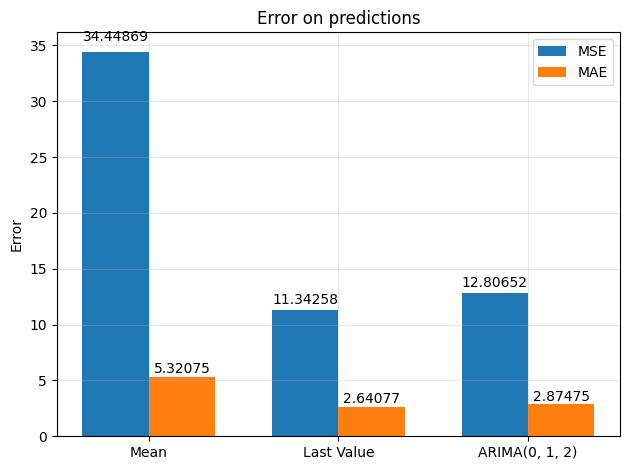

================= Crop production index (2014-2016 = 100) ===================


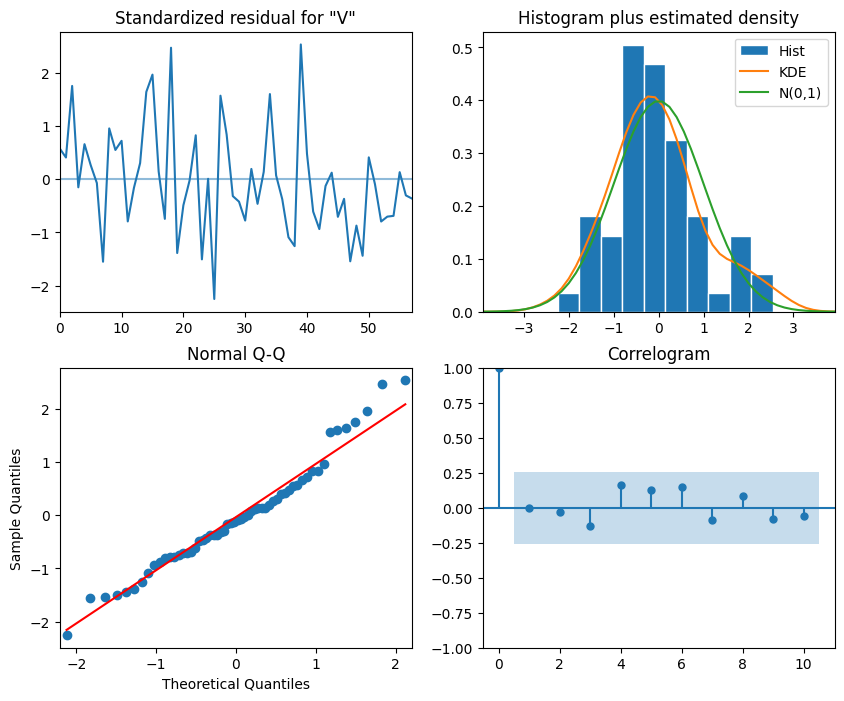

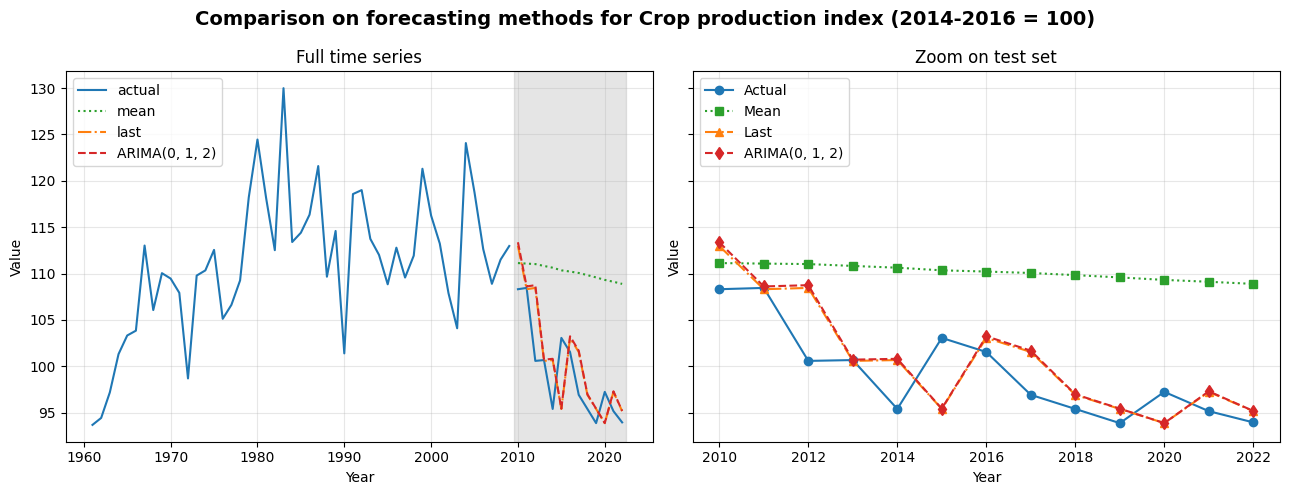

MAE -> mean: 10.88208, last: 3.19538, ARIMA(0, 1, 2): 3.29229
MSE -> mean: 136.79719, last: 16.58325, ARIMA(0, 1, 2): 17.51004


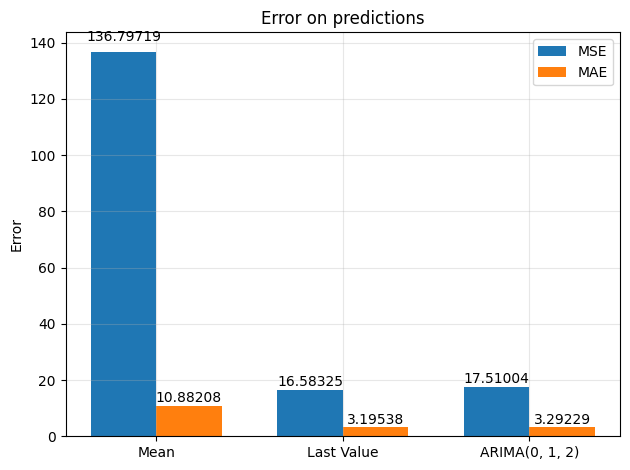

================= Cereal production (metric tons) ===================


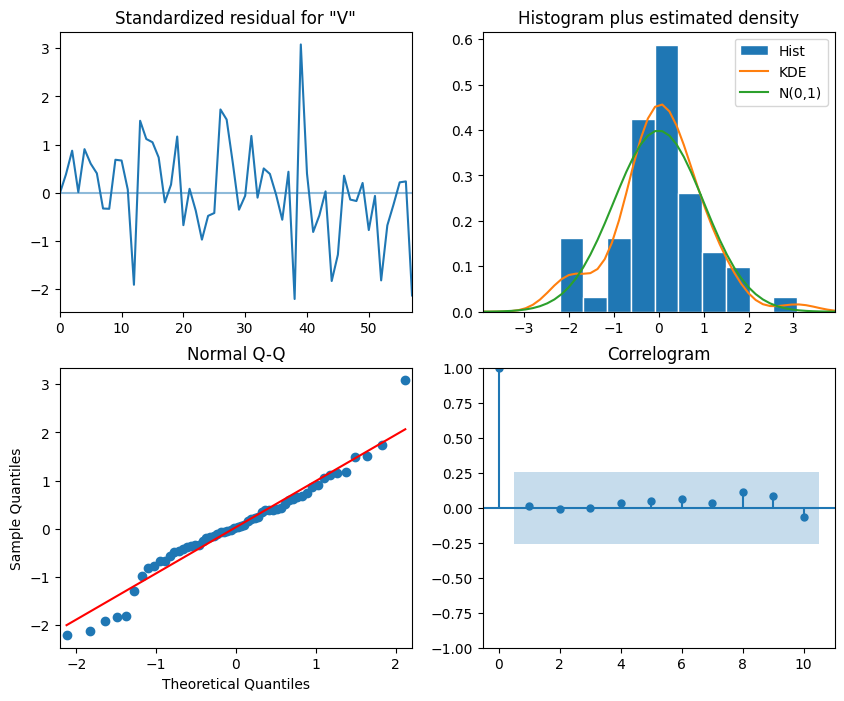

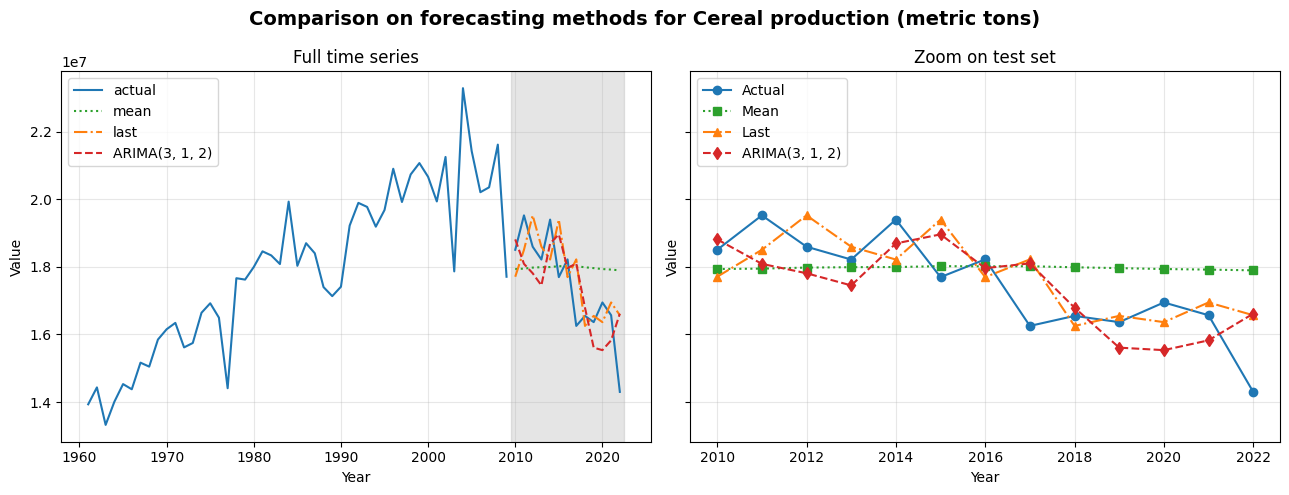

MAE -> mean: 1204114.05895, last: 938943.03077, ARIMA(3, 1, 2): 987120.92422
MSE -> mean: 2216092527368.17139, last: 1297001863436.11963, ARIMA(3, 1, 2): 1342445183455.43091


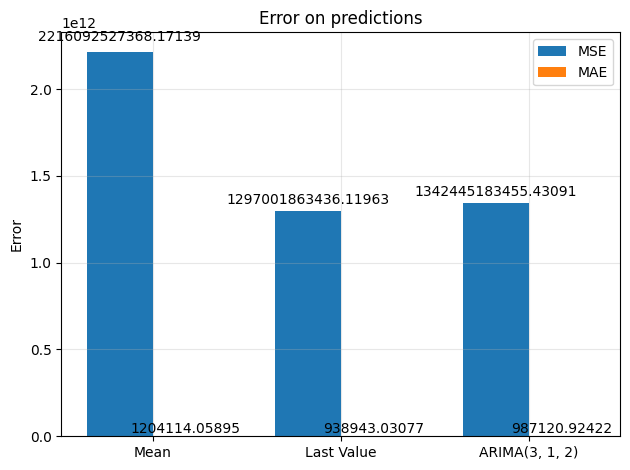

================= Cereal yield (kg per hectare) ===================


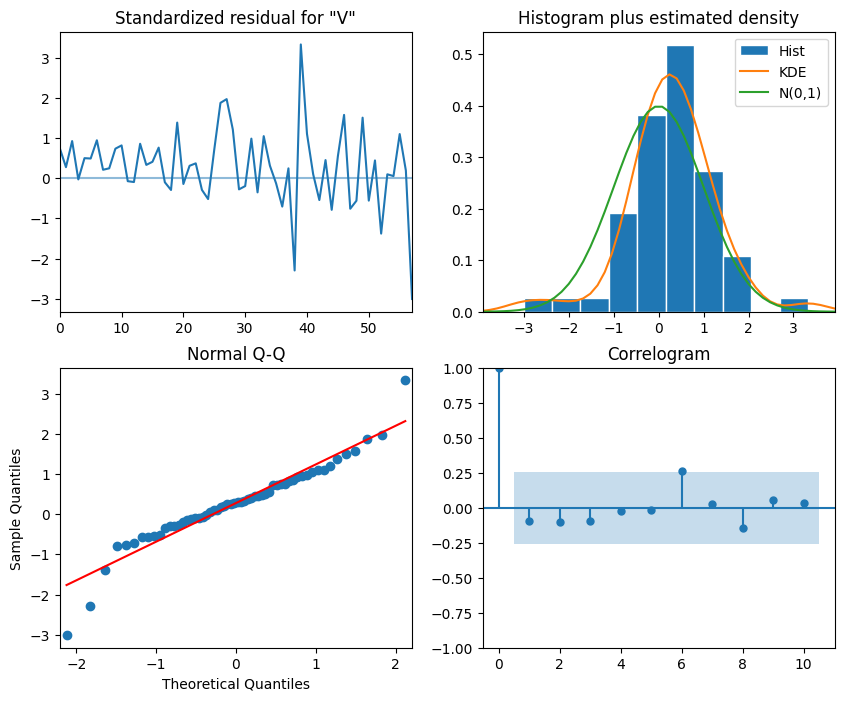

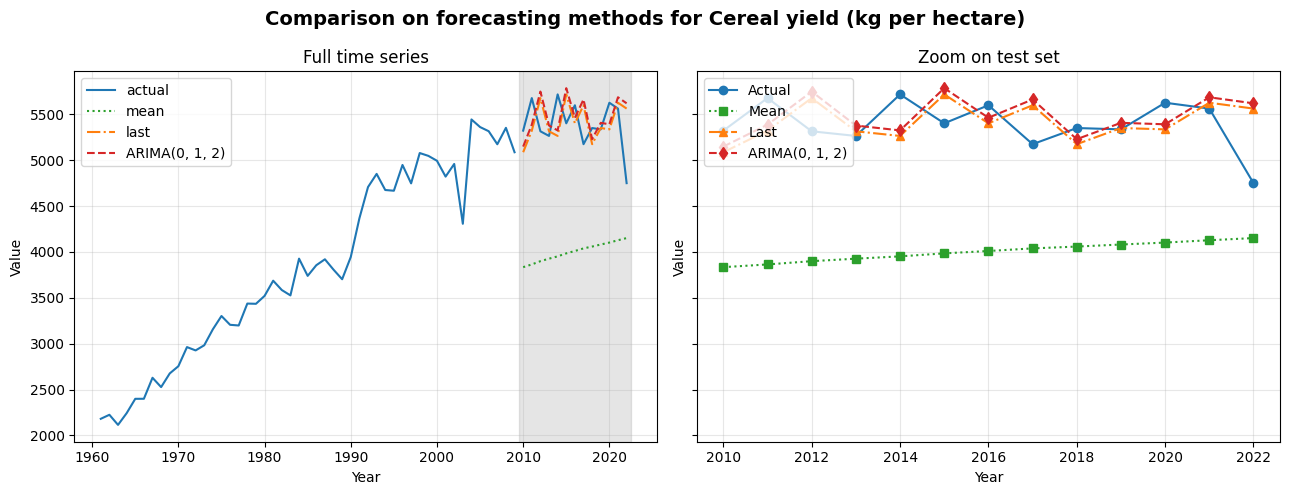

MAE -> mean: 1389.71597, last: 288.42308, ARIMA(0, 1, 2): 294.57320
MSE -> mean: 2016826.14252, last: 124489.17462, ARIMA(0, 1, 2): 132195.79340


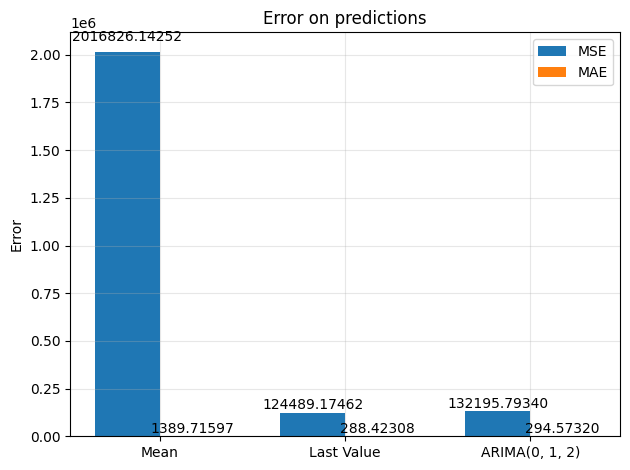

================= Agriculture, forestry, and fishing, value added (% of GDP) ===================


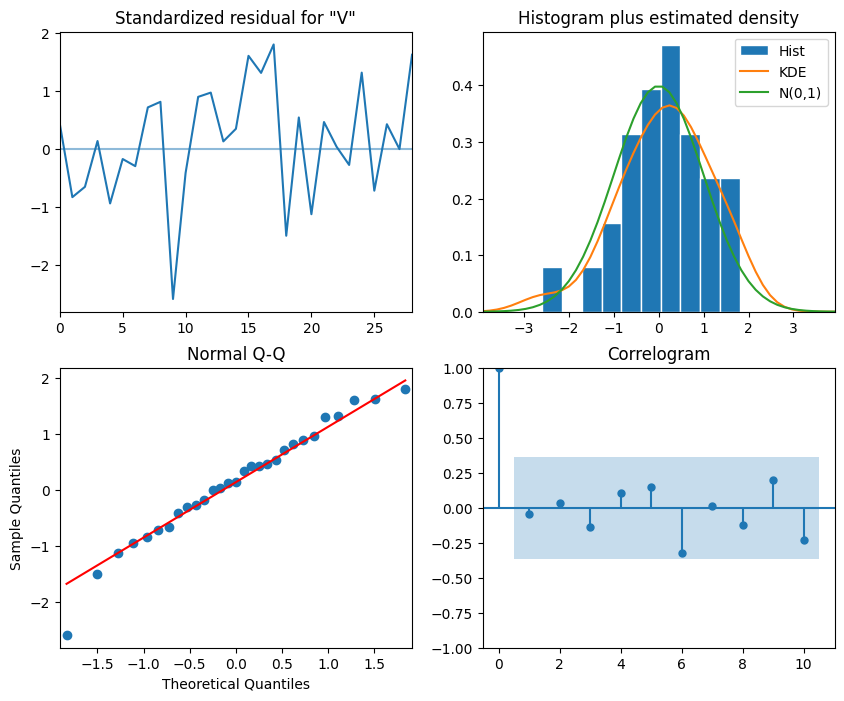

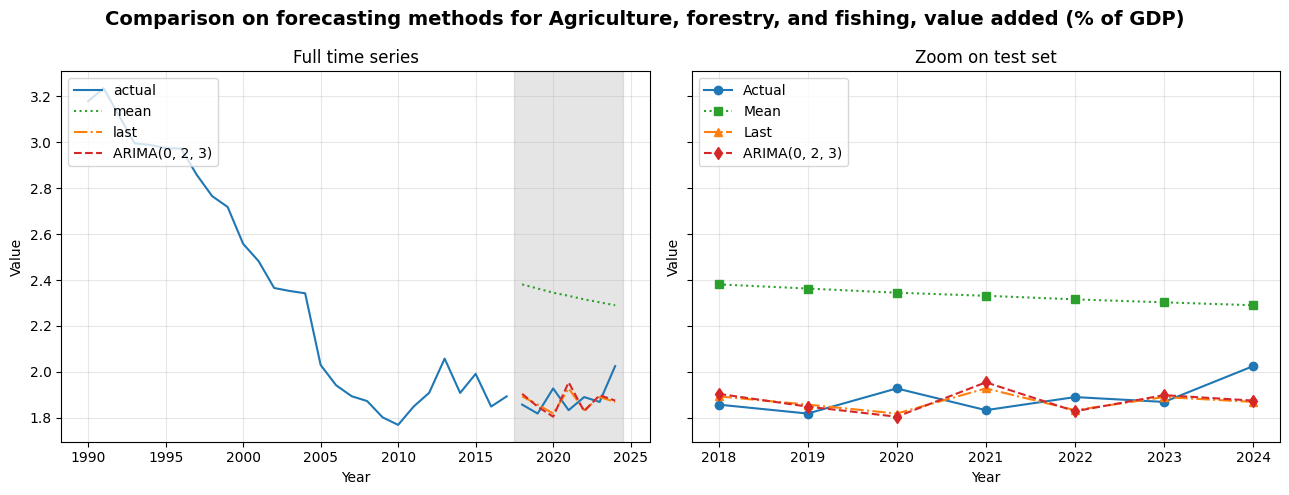

MAE -> mean: 0.44378, last: 0.07328, ARIMA(0, 2, 3): 0.08040
MSE -> mean: 0.20445, last: 0.00740, ARIMA(0, 2, 3): 0.00860


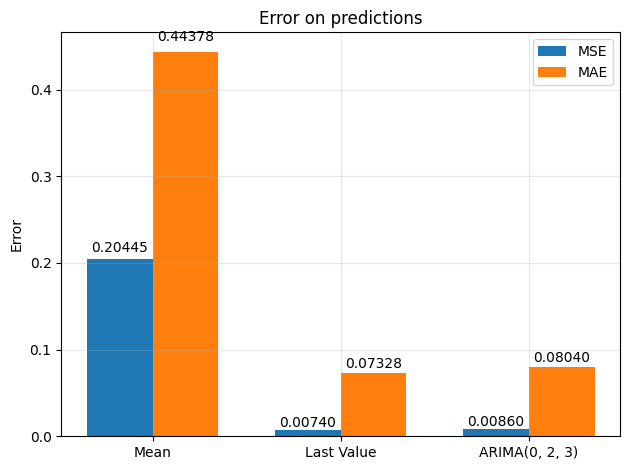

================= Agriculture, forestry, and fishing, value added (current US$) ===================


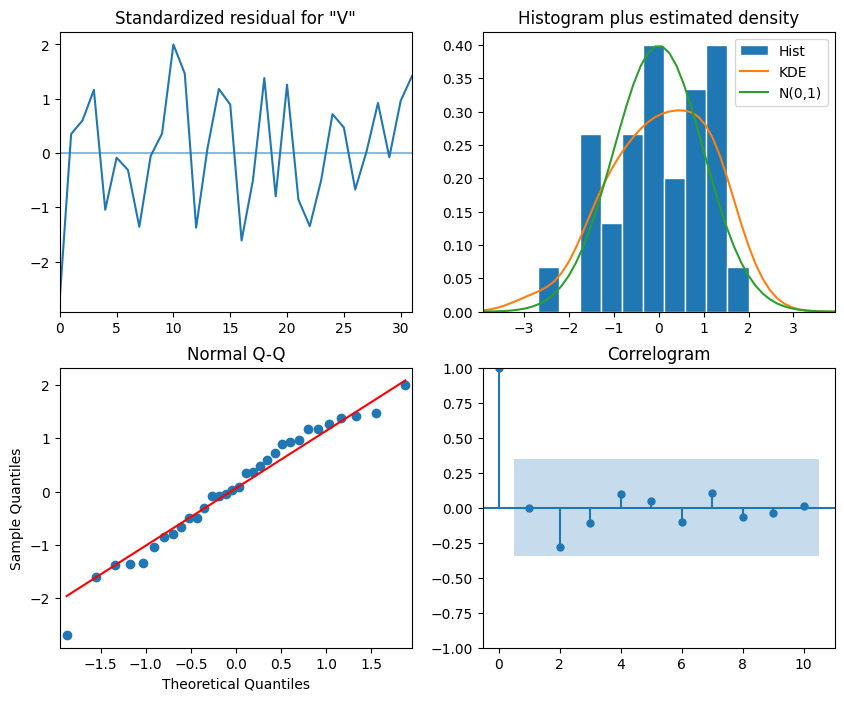

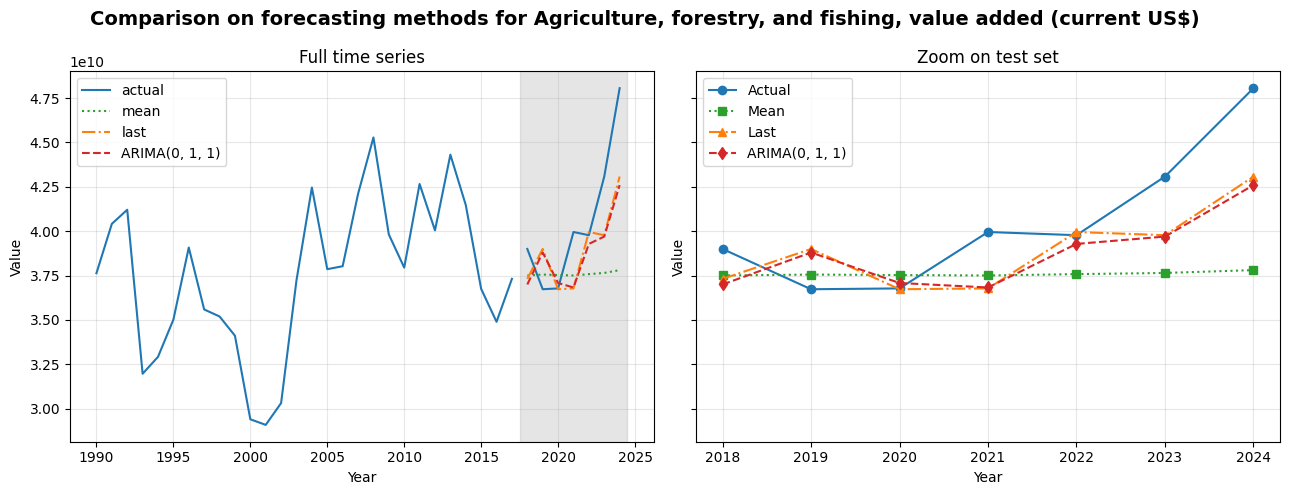

MAE -> mean: 3342123178.36352, last: 2233723104.14788, ARIMA(0, 1, 1): 2404541337.07118
MSE -> mean: 21261574613668966400.00000, last: 7685912652876789760.00000, ARIMA(0, 1, 1): 8519134242297708544.00000


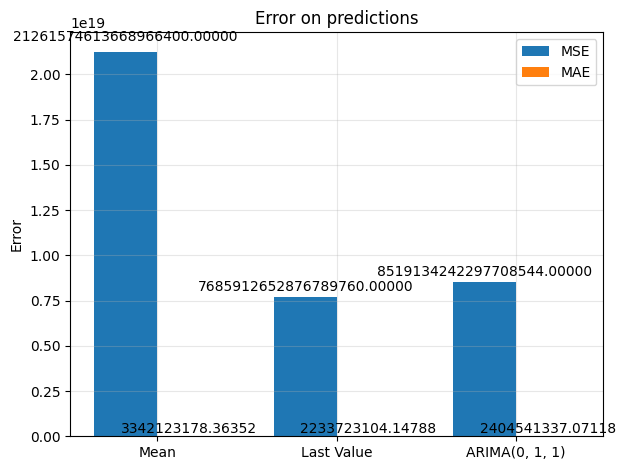

In [ ]:
if __name__ == "__main__":
    for indicator in indicators:
        df_temp = (
            df[df["Indicator Name"] == indicator]
            .melt(id_vars=["Indicator Name"], var_name="Year", value_name="Value")
            .assign(Year=lambda d: d["Year"].astype(int))
            .dropna(subset=["Value"])
            [["Year", "Value"]]
            .reset_index(drop=True)
        )
        if df_temp.empty or len(df_temp) < 20 or df_temp['Value'].nunique() == 1: continue
        if test_stationarity(df_temp['Value']): continue
        
        print(f"================= {indicator} ===================")
        row = df_orders[df_orders["Indicator"] == indicator]
        if row.empty:
            print(f"Indicator '{indicator}' not found in df_orders, skipping.")
            continue
        best_order_val = row["Best order"].iloc[0]

        try:
            if isinstance(best_order_val, str):
                order = ast.literal_eval(best_order_val)
            elif isinstance(best_order_val, (tuple, list)):
                order = tuple(best_order_val)
            else:
                order = tuple(best_order_val)
            if len(order) != 3:
                raise ValueError("order length != 3")
            p, d, q = (int(order[0]), int(order[1]), int(order[2]))
        except Exception as e:
            print(f"Could not parse Best order for '{indicator}': {e}. Skipping.")
            continue
        
        model = ARIMA(df_temp['Value'], order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
        fitted = model.fit()
        residuals = fitted.resid.dropna()
        # print(fitted.summary())
        plt.close('all')
        
        # PLOT DIAGNOSTICS
        fitted.plot_diagnostics(figsize=(10,8))
        plt.show()
        
        train = df_temp[:int(0.8*len(df_temp))]
        test = df_temp[int(0.8*len(df_temp)):]
        
        TRAIN_LEN = len(train)
        HORIZON = len(test)
        WINDOW = 1

        pred_mean = rolling_forecast(df_temp, TRAIN_LEN, HORIZON, WINDOW, 'mean', p, q, d)
        pred_last_value = rolling_forecast(df_temp, TRAIN_LEN, HORIZON, WINDOW, 'last', p, q, d)
        pred_ARIMA = rolling_forecast(df_temp, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA', p, q, d)

        test = df_temp.iloc[TRAIN_LEN:TRAIN_LEN+HORIZON].copy()
        test['pred_mean'] = pred_mean[:HORIZON]
        test['pred_last_value'] = pred_last_value[:HORIZON]
        test['pred_ARIMA'] = pred_ARIMA[:HORIZON]
        
        plot_forecasts(indicator, train, test)
        
        # mae e mse a confronto
        mae_mean = mean_absolute_error(test['Value'], test['pred_mean'])
        mae_last = mean_absolute_error(test['Value'], test['pred_last_value'])
        mae_arima = mean_absolute_error(test['Value'], test['pred_ARIMA'])

        mse_mean = mean_squared_error(test['Value'], test['pred_mean'])
        mse_last = mean_squared_error(test['Value'], test['pred_last_value'])
        mse_arima = mean_squared_error(test['Value'], test['pred_ARIMA'])
        
        print(f"MAE -> mean: {mae_mean:.5f}, last: {mae_last:.5f}, ARIMA{(p,d,q)}: {mae_arima:.5f}")
        print(f"MSE -> mean: {mse_mean:.5f}, last: {mse_last:.5f}, ARIMA{(p,d,q)}: {mse_arima:.5f}")
        
        results = pd.DataFrame({
            'Method': ['Mean', 'Last Value', f'ARIMA{(p,d,q)}'],
            'MSE': [mse_mean, mse_last, mse_arima],
            'MAE': [mae_mean, mae_last, mae_arima]
        })
        
        plot_error(results)
